In [1]:
# Note: some of the code are copied from Kaggle's lessons

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
#         print(os.path.join(dirname, filename))
        pass

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectFromModel


from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import lightgbm as lgb


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Files 
GSPC_path='./data/^GSPC.csv'
can_unemp_path='./data/can_unempemp.csv'
us_unemp_path='./data/us_UNRATE.csv'
DJI_path='./data/^DJI.csv'
FVX_path='./data/^FVX.csv'
GSPTSE_path='./data/^GSPTSE.csv'
IRX_path='./data/^IRX.csv'
IXIC_path='./data/^IXIC.csv'
N225_path='./data/^N225.csv'
TNX_path='./data/^TNX.csv'
TYX_path='./data/^TYX.csv'
usGDP_path='./data/usGDP.csv'
non_farm_path='./data/non_farm.csv'
us_CPI_path='./data/OECD_CPI_Total_All_Items.csv'

In [4]:
GSPC = pd.read_csv(GSPC_path, index_col='Date',parse_dates=True)
can_unemp = pd.read_csv(can_unemp_path, index_col='Date',parse_dates=True)
us_unemp = pd.read_csv(us_unemp_path, index_col='DATE',parse_dates=True)

DJI = pd.read_csv(DJI_path, index_col='Date',parse_dates=True)
FVX = pd.read_csv(FVX_path, index_col='Date',parse_dates=True)
GSPTSE = pd.read_csv(GSPTSE_path, index_col='Date',parse_dates=True)
IRX = pd.read_csv(IRX_path, index_col='Date',parse_dates=True)
IXIC = pd.read_csv(IXIC_path, index_col='Date',parse_dates=True)
N225 = pd.read_csv(N225_path, index_col='Date',parse_dates=True)
TNX = pd.read_csv(TNX_path, index_col='Date',parse_dates=True)
TYX = pd.read_csv(TYX_path, index_col='Date',parse_dates=True)

usGDP = pd.read_csv(usGDP_path, index_col='DATE',parse_dates=True)
non_farm = pd.read_csv(non_farm_path, index_col='DATE',parse_dates=True)
us_CPI = pd.read_csv(us_CPI_path, index_col='DATE',parse_dates=True)


In [5]:
def stock_use_close_value(df):
    headers_to_drop=['Open', 'High','Low','Adj Close','test','Volume']
    current_cols=df.columns
#     df['Close-Open']=df['Close']-df['Open']
    for header in headers_to_drop:
        if header in current_cols:
            df=df.drop(columns = header)
    if 'Close' in current_cols:
        pass
#         df['Close']=df['Close'].apply(np.log)
    return df


def data_prepare(df,name):
    df=df.dropna()
    df=df.resample('D').interpolate(method='cubic') #TODO: possible data leak
    
    for col in df.columns:
        df=df.rename(columns={col : (name+'_'+col)})
    return df


In [6]:
GSPC=data_prepare(stock_use_close_value(GSPC),'GSPC')
can_unemp=data_prepare(can_unemp,'can_unemp')
us_unemp=data_prepare(us_unemp,'us_unemp')

DJI=data_prepare(stock_use_close_value(DJI),'DJI')
FVX=data_prepare(stock_use_close_value(FVX),'FVX')
GSPTSE=data_prepare(stock_use_close_value(GSPTSE),'GSPTSE')
IRX=data_prepare(stock_use_close_value(IRX),'IRX')
IXIC=data_prepare(stock_use_close_value(IXIC),'IXIC')
N225=data_prepare(stock_use_close_value(N225),'N225')
TNX=data_prepare(stock_use_close_value(TNX),'TNX')
TYX=data_prepare(stock_use_close_value(TYX),'TYX')

usGDP=data_prepare(usGDP,'usGDP')
non_farm=data_prepare(non_farm,'non_farm')
us_CPI=data_prepare(us_CPI,'us_CPI')




econ_data_ori=GSPC.copy()
# econ_data_ori=econ_data_ori.join(can_unemp)
econ_data_ori=econ_data_ori.join(us_unemp)
econ_data_ori=econ_data_ori.join(DJI)
# econ_data_ori=econ_data_ori.join(FVX)
# econ_data_ori=econ_data_ori.join(GSPTSE)
# econ_data_ori=econ_data_ori.join(IRX)
# econ_data_ori=econ_data_ori.join(IXIC)
econ_data_ori=econ_data_ori.join(N225)
# econ_data_ori=econ_data_ori.join(TNX)
# econ_data_ori=econ_data_ori.join(TYX)


# econ_data_ori=econ_data_ori.join(usGDP)
# econ_data_ori=econ_data_ori.join(non_farm)
# econ_data_ori=econ_data_ori.join(us_CPI)


current_time_features=econ_data_ori.columns
econ_data_ori

GSPC_Close  us_unemp_UNRATE     DJI_Close    N225_Close
Date                                                                
1950-01-03    16.660000         6.484862           NaN           NaN
1950-01-04    16.850000         6.477920           NaN           NaN
1950-01-05    16.930000         6.471378           NaN           NaN
1950-01-06    16.980000         6.465225           NaN           NaN
1950-01-07    17.048521         6.459447           NaN           NaN
...                 ...              ...           ...           ...
2019-09-13  3007.389893              NaN  27219.519531  21988.289063
2019-09-14  3002.211764              NaN  27195.178014  22239.241389
2019-09-15  2997.932843              NaN  27126.278833  22400.024966
2019-09-16  2997.959961              NaN  27076.820313  22358.198403
2019-09-17  3005.699951              NaN  27110.800781  22001.320313

[25460 rows x 4 columns]

In [7]:

def rolling_mean(series,duration):
    return (series.rolling(duration, win_type='blackman').mean())

def rolling_pstd(series,duration):
    cat = lambda x: (x - x.mean()) / x.std()   
    series=series.dropna()
    series=series.replace([np.inf, -np.inf], np.nan).fillna(series.mean())
    return (series.rolling(duration).std()/series*100).replace([np.inf, -np.inf], np.nan).fillna(series.mean())


def sp_cat(x):
    if (x > 4.0):
        return 2

    if (x> 1.0):
        return 1

    if (x > -1.0):
        return 0

    if (x >-4.0):
        return -1

    if (x <-4.0):
        return -2



def smooth_data(df, features_to_smooth, tap=10):
    for col in features_to_smooth:
        df[col+'_smoothed']=rolling_mean(df[col],tap).shift(periods=int(-tap/2))
    return df

def trend_predict(series, target_distance, sampling_period=30, order=1):
    
    series=series.dropna()
    
    list_of_values_in_window = []
    series.rolling(sampling_period).apply(lambda x: list_of_values_in_window.append(x.values) or 0, raw=False)
    slopes=[]
    for arr in list_of_values_in_window:
        simple_fit = (np.polyfit(range(sampling_period), arr, order))
        poly_func = np.poly1d(simple_fit)
        pred=poly_func(target_distance-1+sampling_period)
        slopes.append(pred)

    pred_series=pd.Series(slopes, (series.index[:1-sampling_period]))
    
    return pred_series
    
def inverted_in_past_duration(series_high,series_low,duration):
    series=series_high-series_low
    def min_is_negative (arr):
        min_val=np.min(arr)
        if min_val<=0:
            return 1
        else: return 0
    return (series.rolling(duration).apply(min_is_negative))

    
    return pred_series
def trendline(series, tap, name='slopes', order=1):
    series=series.dropna()
    series=series[series.notna()]
    start_date=series.first_valid_index()
    end_date=series.last_valid_index()

    series=series[series.index>=start_date]
    series=series[series.index<=end_date]
    
    list_of_values_in_window = []
    series.rolling(tap).apply(lambda x: list_of_values_in_window.append(x.values) or 0, raw=False)
      
    slopes = [(np.polyfit(range(tap), arr, order))[-2] for arr in list_of_values_in_window]

    slopes_series=pd.Series(slopes, (series.index[tap-1:]))

    return slopes_series

def stock_utility(series_list, name_list=[], delay_days=[],trendline_days=[], std_days=[]):
    df = pd.DataFrame()
    if not isinstance(series_list, pd.DataFrame):
        col_list=[0]
        series_list=[series_list]
    else:
        col_list= series_list.columns
        
    if not isinstance(name_list, list):
        name_list=[name_list]    
        
    if not isinstance(trendline_days, list):
        trendline_days=[trendline_days]  
        
    if not isinstance(std_days, list):
        std_days=[std_days]  
    
    
    for i in range(len(col_list)):
        series=series_list[col_list[i]].dropna()
        if i >= len(name_list):
            name = series.name
        else:
            name=name_list[i]
        print('stock_utility is working on '+name)
        
        for dd in delay_days:
            df[name+'_'+str(dd)+'d']=series.shift(periods=dd)

        for td in trendline_days:
            series_name=name+'_'+str(td)+'days_trendline'
            df[series_name]=trendline(series,td,series_name)

        for sd in std_days:
            series_name=name+'_'+str(sd)+'days_pSTD'
            df[series_name]=rolling_pstd(series,sd)

    return df

def poly_extrapolate (df,target_distance, sampling_period=[30], order=1):
    new_df = pd.DataFrame()
    if not isinstance(df, pd.DataFrame):
        col_list=[0]
        df=[df]
    else:
        col_list= df.columns
        
    if not isinstance(sampling_period, list):
        sampling_period=[sampling_period]  
        
    
    for i in range(len(col_list)):
        series=df[col_list[i]].dropna()
        name = series.name
        target_distance=[int(s) for s in str(name).replace('days','').replace('d','').split('_') if s.isdigit()][-1]
        print('extrapolating '+name)

        for sp in sampling_period:
            series_name=name+'_'+str(sp)+'days_'+str(order)+'order_extrapolated'
            new_df[series_name]=trend_predict(series, target_distance, sp, order)            

    return new_df

def p_diff_err (ref_series,diff_series):
    result=(abs(diff_series-ref_series)/ref_series).dropna().values.mean()*100
    print ('The absolut error is {:.3f}%'.format(result))
    return result

def diff_err_scorer (ref_series,diff_series):
    result=(((100*abs(diff_series-ref_series)/ref_series)**3)).dropna().values.mean()
    result=result**(0.5)
    print ('The custom error is {:.3f}'.format(result))
    return result

def normalize_stock (df,target_days,additional_features =[] ,key_word="Close", negative_keyword='STD'):
    features_to_norm = [f for f in df.columns if (key_word in f and negative_keyword not in f)]
    features_to_norm =list(features_to_norm) + additional_features
    features_to_norm = list(dict.fromkeys(features_to_norm))
    normed_features = [feature +'_'+str(target_days)+'days_ratio' for feature in features_to_norm]
    df[normed_features]=((df[features_to_norm]/df[features_to_norm].shift(periods=target_days))-1)*100
    return df

In [8]:
def data_init_wrapper (df, target_days, important_features=['GSPC_Close']):
    new_df= df.copy()
    ori_features=df.columns
    smoothed_features = [f for f in list(ori_features) if "smoothed" in f]
    not_important_std_features = [f for f in list(ori_features) if f not in (smoothed_features + important_features)]
    important_std_features = [f for f in list(ori_features) if (f not in smoothed_features and f in important_features)]
    print('not_important_std_features='+str(not_important_std_features))
    print('important_std_features='+str(important_std_features))
    
#     remove not smooth or not std features
    features_to_drop=[f for f in list(new_df.columns) if (("smoothed" not in f) and ("STD" not in f))]
    new_df=new_df.drop(columns=features_to_drop)

    target='GSPC_Close_smoothed_'+str(target_days)+'days_ratio'
    
    important_features.append(target)
    important_features=[f for f in important_features if f not in features_to_drop]
    
    additional_features_to_normalize=[]
    if 'non_farm_non_Farm_smoothed' in ori_features:
        additional_features_to_normalize.append('non_farm_non_Farm_smoothed')
    if 'usGDP_usGDP_smoothed' in ori_features:
        additional_features_to_normalize.append('usGDP_usGDP_smoothed')
    
    new_df=normalize_stock(new_df, target_days, additional_features=additional_features_to_normalize)

    trendline_features=list(new_df.columns)
    
    not_important_trendline_features=[f for f in list(trendline_features) if f not in (important_features)]
    important_trendline_features=[f for f in list(trendline_features) if f in (important_features)]
    
    new_df=new_df.join( stock_utility(new_df[not_important_trendline_features],trendline_days=[target_days]) )
    
    new_df=new_df.join(stock_utility(new_df[important_trendline_features],trendline_days=[target_days]))
    
    features_to_delay=list(new_df.columns)
    features_to_delay.remove(target)   
    
    output_df=stock_utility(new_df,delay_days=[target_days])
    
    features_to_add_extrapolation=[f for f in list(output_df.columns) if ('trendline' not in f)]
    
    order1_extrapolation=(poly_extrapolate(output_df[features_to_add_extrapolation],target_days, sampling_period=[30,target_days], order=1))
    output_df=output_df.join(poly_extrapolate(output_df[features_to_add_extrapolation],target_days, sampling_period=[30,target_days], order=2))
    output_df=output_df.join(order1_extrapolation)
    
    output_df=output_df.join(new_df[target])
    

    return output_df

In [9]:
econ_data=econ_data_ori.copy()
econ_data.name='econ_data'
prediction_distance=30
# Add features
econ_data=smooth_data(econ_data,current_time_features,prediction_distance)

econ_data_processed = data_init_wrapper(econ_data, prediction_distance)
econ_data=econ_data_processed

target='GSPC_Close_smoothed_'+str(prediction_distance)+'days_ratio'

not_important_std_features=['us_unemp_UNRATE', 'DJI_Close', 'N225_Close']
important_std_features=['GSPC_Close']
stock_utility is working on GSPC_Close_smoothed
stock_utility is working on us_unemp_UNRATE_smoothed
stock_utility is working on DJI_Close_smoothed
stock_utility is working on N225_Close_smoothed
stock_utility is working on DJI_Close_smoothed_30days_ratio
stock_utility is working on N225_Close_smoothed_30days_ratio
stock_utility is working on GSPC_Close_smoothed_30days_ratio
stock_utility is working on GSPC_Close_smoothed
stock_utility is working on us_unemp_UNRATE_smoothed
stock_utility is working on DJI_Close_smoothed
stock_utility is working on N225_Close_smoothed
stock_utility is working on GSPC_Close_smoothed_30days_ratio
stock_utility is working on DJI_Close_smoothed_30days_ratio
stock_utility is working on N225_Close_smoothed_30days_ratio
stock_utility is working on GSPC_Close_smoothed_30days_trendline
stock_utility is working on us_unemp_UNRATE_smoothed_30days_trendli

In [10]:
start_date=max(econ_data.apply(lambda series: series.first_valid_index()))
end_date=min(econ_data.apply(lambda series: series.last_valid_index()))

econ_data=econ_data[econ_data.index>=start_date]
econ_data=econ_data[econ_data.index<=end_date]

# econ_data.drop(index=pd.to_datetime('1950-01-03'))
econ_data

GSPC_Close_smoothed_30d  us_unemp_UNRATE_smoothed_30d  \
Date                                                                
1985-05-12               180.135630                      7.258506   
1985-05-13               180.310349                      7.254004   
1985-05-14               180.484143                      7.249466   
1985-05-15               180.649737                      7.244937   
1985-05-16               180.801631                      7.240457   
...                             ...                           ...   
2019-06-14              2850.388563                      3.651233   
2019-06-15              2847.794929                      3.654743   
2019-06-16              2845.555063                      3.658209   
2019-06-17              2843.415753                      3.661623   
2019-06-18              2841.100599                      3.664975   

            DJI_Close_smoothed_30d  N225_Close_smoothed_30d  \
Date                                                          
1985-05-12             1263.432438             12504.594130   
1985-05-13             1264.235975             12474.547361   
1985-05-14             1265.064009             12442.258137   
1985-05-15             1265.878303             12409.198008   
1985-05-16             1266.647022             12377.073663   
...                            ...                      ...   
2019-06-14            25697.084984             21288.516373   
2019-06-15            25681.505533             21265.827790   
2019-06-16            25670.003821             21249.163202   
2019-06-17            25659.946799             21236.002500   
2019-06-18            25648.439422             21223.813109   

            GSPC_Close_smoothed_30days_ratio_30d  \
Date                                               
1985-05-12                              1.084040   
1985-05-13                              1.267848   
1985-05-14                              1.418733   
1985-05-15                              1.532861   
1985-05-16                              1.609080   
...                                          ...   
2019-06-14                             -1.838279   
2019-06-15                             -1.976097   
2019-06-16                             -2.107802   
2019-06-17                             -2.243663   
2019-06-18                             -2.394106   

            DJI_Close_smoothed_30days_ratio_30d  \
Date                                              
1985-05-12                             0.159876   
1985-05-13                             0.332210   
1985-05-14                             0.472873   
1985-05-15                             0.578870   
1985-05-16                             0.650003   
...                                         ...   
2019-06-14                            -2.784759   
2019-06-15                            -2.909168   
2019-06-16                            -3.015386   
2019-06-17                            -3.111072   
2019-06-18                            -3.205206   

            N225_Close_smoothed_30days_ratio_30d  \
Date                                               
1985-05-12                              0.663794   
1985-05-13                              0.327173   
1985-05-14                             -0.037297   
1985-05-15                             -0.411659   
1985-05-16                             -0.776609   
...                                          ...   
2019-06-14                             -3.547604   
2019-06-15                             -3.791328   
2019-06-16                             -3.992732   
2019-06-17                             -4.162087   
2019-06-18                             -4.310918   

            GSPC_Close_smoothed_30days_trendline_30d  \
Date                                                   
1985-05-12                                  0.075174   
1985-05-13                                  0.075135   
1985-05-14                                  0.074569

In [11]:
econ_data=econ_data.dropna()
econ_data=econ_data.astype(np.float32)

valid_fraction = 0.1
valid_size = int(len(econ_data) * valid_fraction)

# valid_size=365

# train = econ_data[:-1* 365]
# valid = econ_data[-365:]

econ_data=econ_data.round(10)
econ_data.fillna(0)
econ_data=econ_data.replace(np.inf, 1e10)
econ_data=econ_data.replace(-np.inf, -1e5)



for col in econ_data.columns:
    a = np.array(econ_data[col].values.tolist())
    econ_data[col] = np.where(a > 1e10, 1e10, a).tolist()
    


train = econ_data[:-2*valid_size]
valid = econ_data[-2 * valid_size:-valid_size]
test = econ_data[-valid_size:]

feature_cols = train.columns.drop(target)


X_train=train[feature_cols]
y_train=train[target]


X_valid=econ_data[-2 * valid_size:][feature_cols]
y_valid=econ_data[-2 * valid_size:][target]





In [12]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, feature_cols)
    ])

# define model
model = RandomForestRegressor(n_estimators=250, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
score = mean_absolute_error(y_valid, preds)
print('Valid MAE:', score)

self_preds = my_pipeline.predict(X_train)
self_score = mean_absolute_error(y_train, self_preds)
print('Training MAE:', self_score)


Valid MAE: 0.5502675999515155
Training MAE: 0.10596286538251817


[4.27091305 4.44026184 4.42937301 4.73529364 5.97071378 5.2717503
 5.01337666 5.9258878  4.67181889 4.67538792 4.8353245  5.01510527
 4.49306942 4.94275858 4.62731681 4.39389861 4.32349118 4.45804594
 5.38930072 5.00597106 4.54551578 4.36262317 4.42549178 4.39660354
 4.52369228 7.         5.45237341 4.80685302]


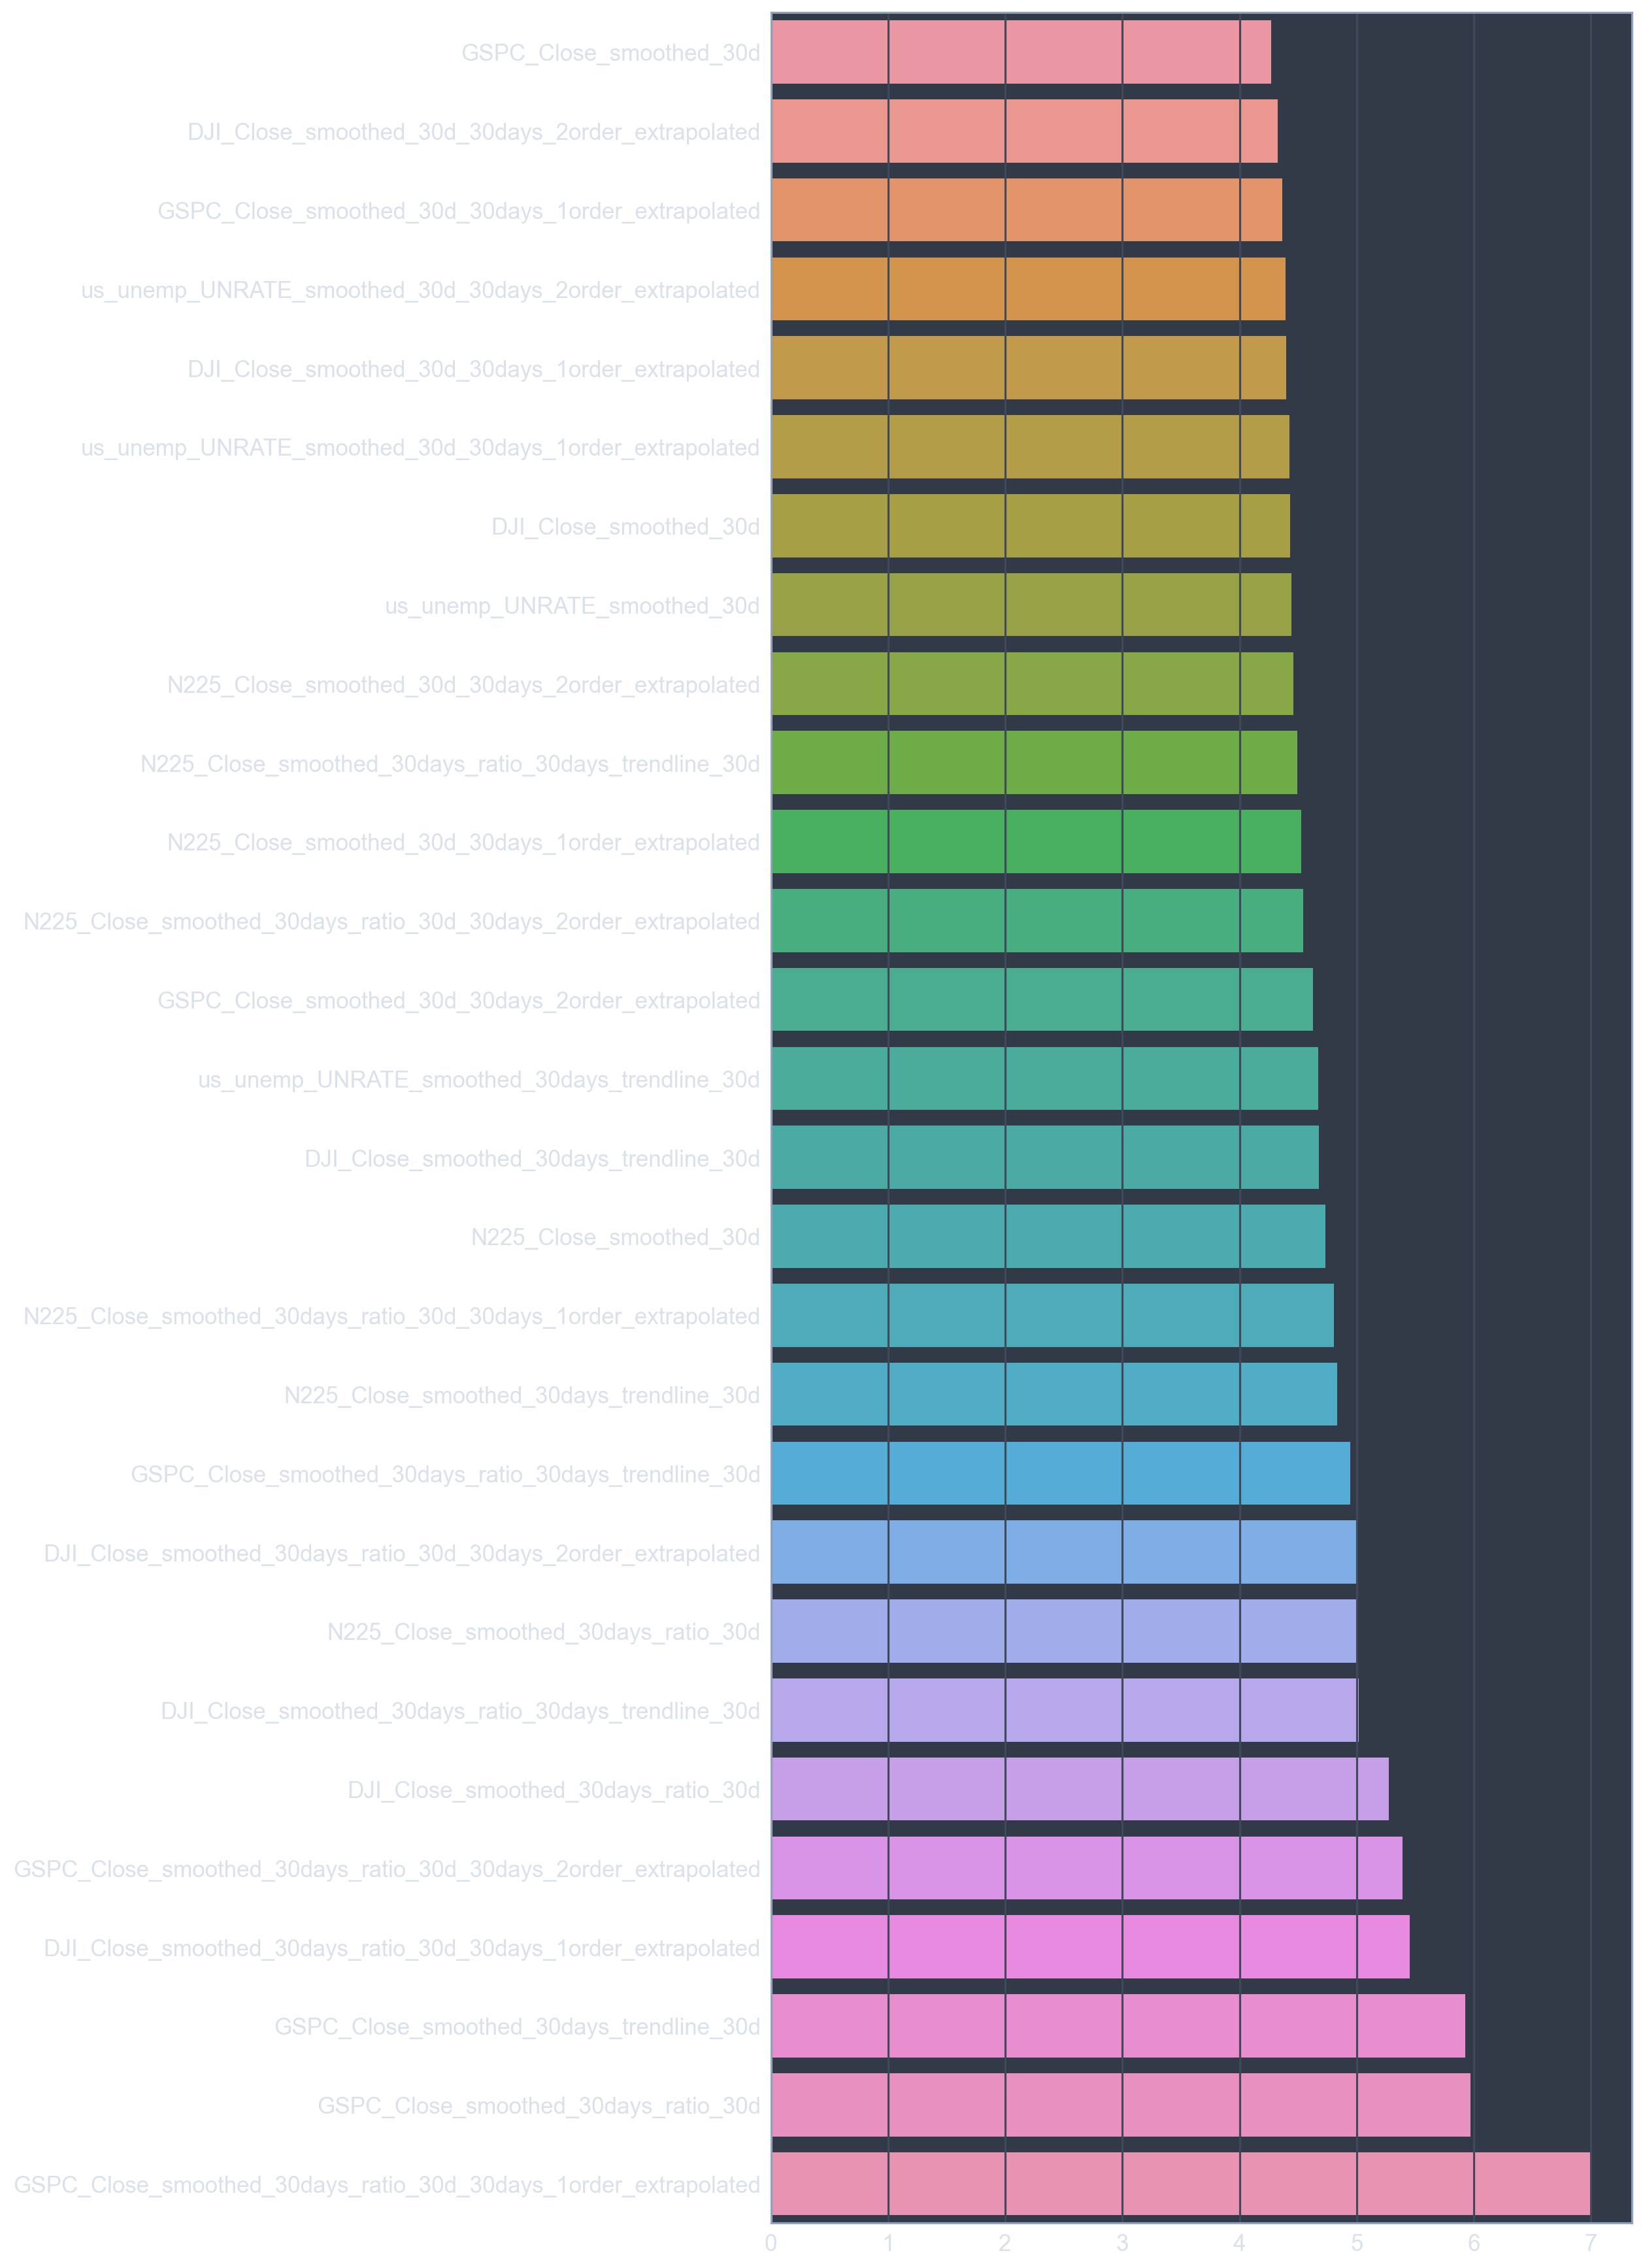

In [13]:
feat_rank=np.log10((my_pipeline.steps[1][1].feature_importances_)/max(my_pipeline.steps[1][1].feature_importances_)*1e7)
# feat_rank=np.log10((quick_model.feature_importances_)/max(quick_model.feature_importances_)*1e7)
plt.figure(figsize=(8.5,0.8*len(list(X_train.columns))), dpi=200)
pd_series = pd.Series(data=feat_rank, index= X_train.columns).sort_values()
sns.barplot(y=pd_series.index, x=pd_series.values)
print(feat_rank)


In [14]:
# pd_series[pd_series.values>3]
print((pd_series.tail(20).index))


Index(['N225_Close_smoothed_30d_30days_2order_extrapolated',
       'N225_Close_smoothed_30days_ratio_30days_trendline_30d',
       'N225_Close_smoothed_30d_30days_1order_extrapolated',
       'N225_Close_smoothed_30days_ratio_30d_30days_2order_extrapolated',
       'GSPC_Close_smoothed_30d_30days_2order_extrapolated',
       'us_unemp_UNRATE_smoothed_30days_trendline_30d',
       'DJI_Close_smoothed_30days_trendline_30d', 'N225_Close_smoothed_30d',
       'N225_Close_smoothed_30days_ratio_30d_30days_1order_extrapolated',
       'N225_Close_smoothed_30days_trendline_30d',
       'GSPC_Close_smoothed_30days_ratio_30days_trendline_30d',
       'DJI_Close_smoothed_30days_ratio_30d_30days_2order_extrapolated',
       'N225_Close_smoothed_30days_ratio_30d',
       'DJI_Close_smoothed_30days_ratio_30days_trendline_30d',
       'DJI_Close_smoothed_30days_ratio_30d',
       'GSPC_Close_smoothed_30days_ratio_30d_30days_2order_extrapolated',
       'DJI_Close_smoothed_30days_ratio_30d_30days_1or

In [15]:
valid_result=y_valid.to_frame()
valid_result['preds']=preds


self_result=y_train.to_frame()
self_result['preds']=self_preds

<AxesSubplot:xlabel='Date'>

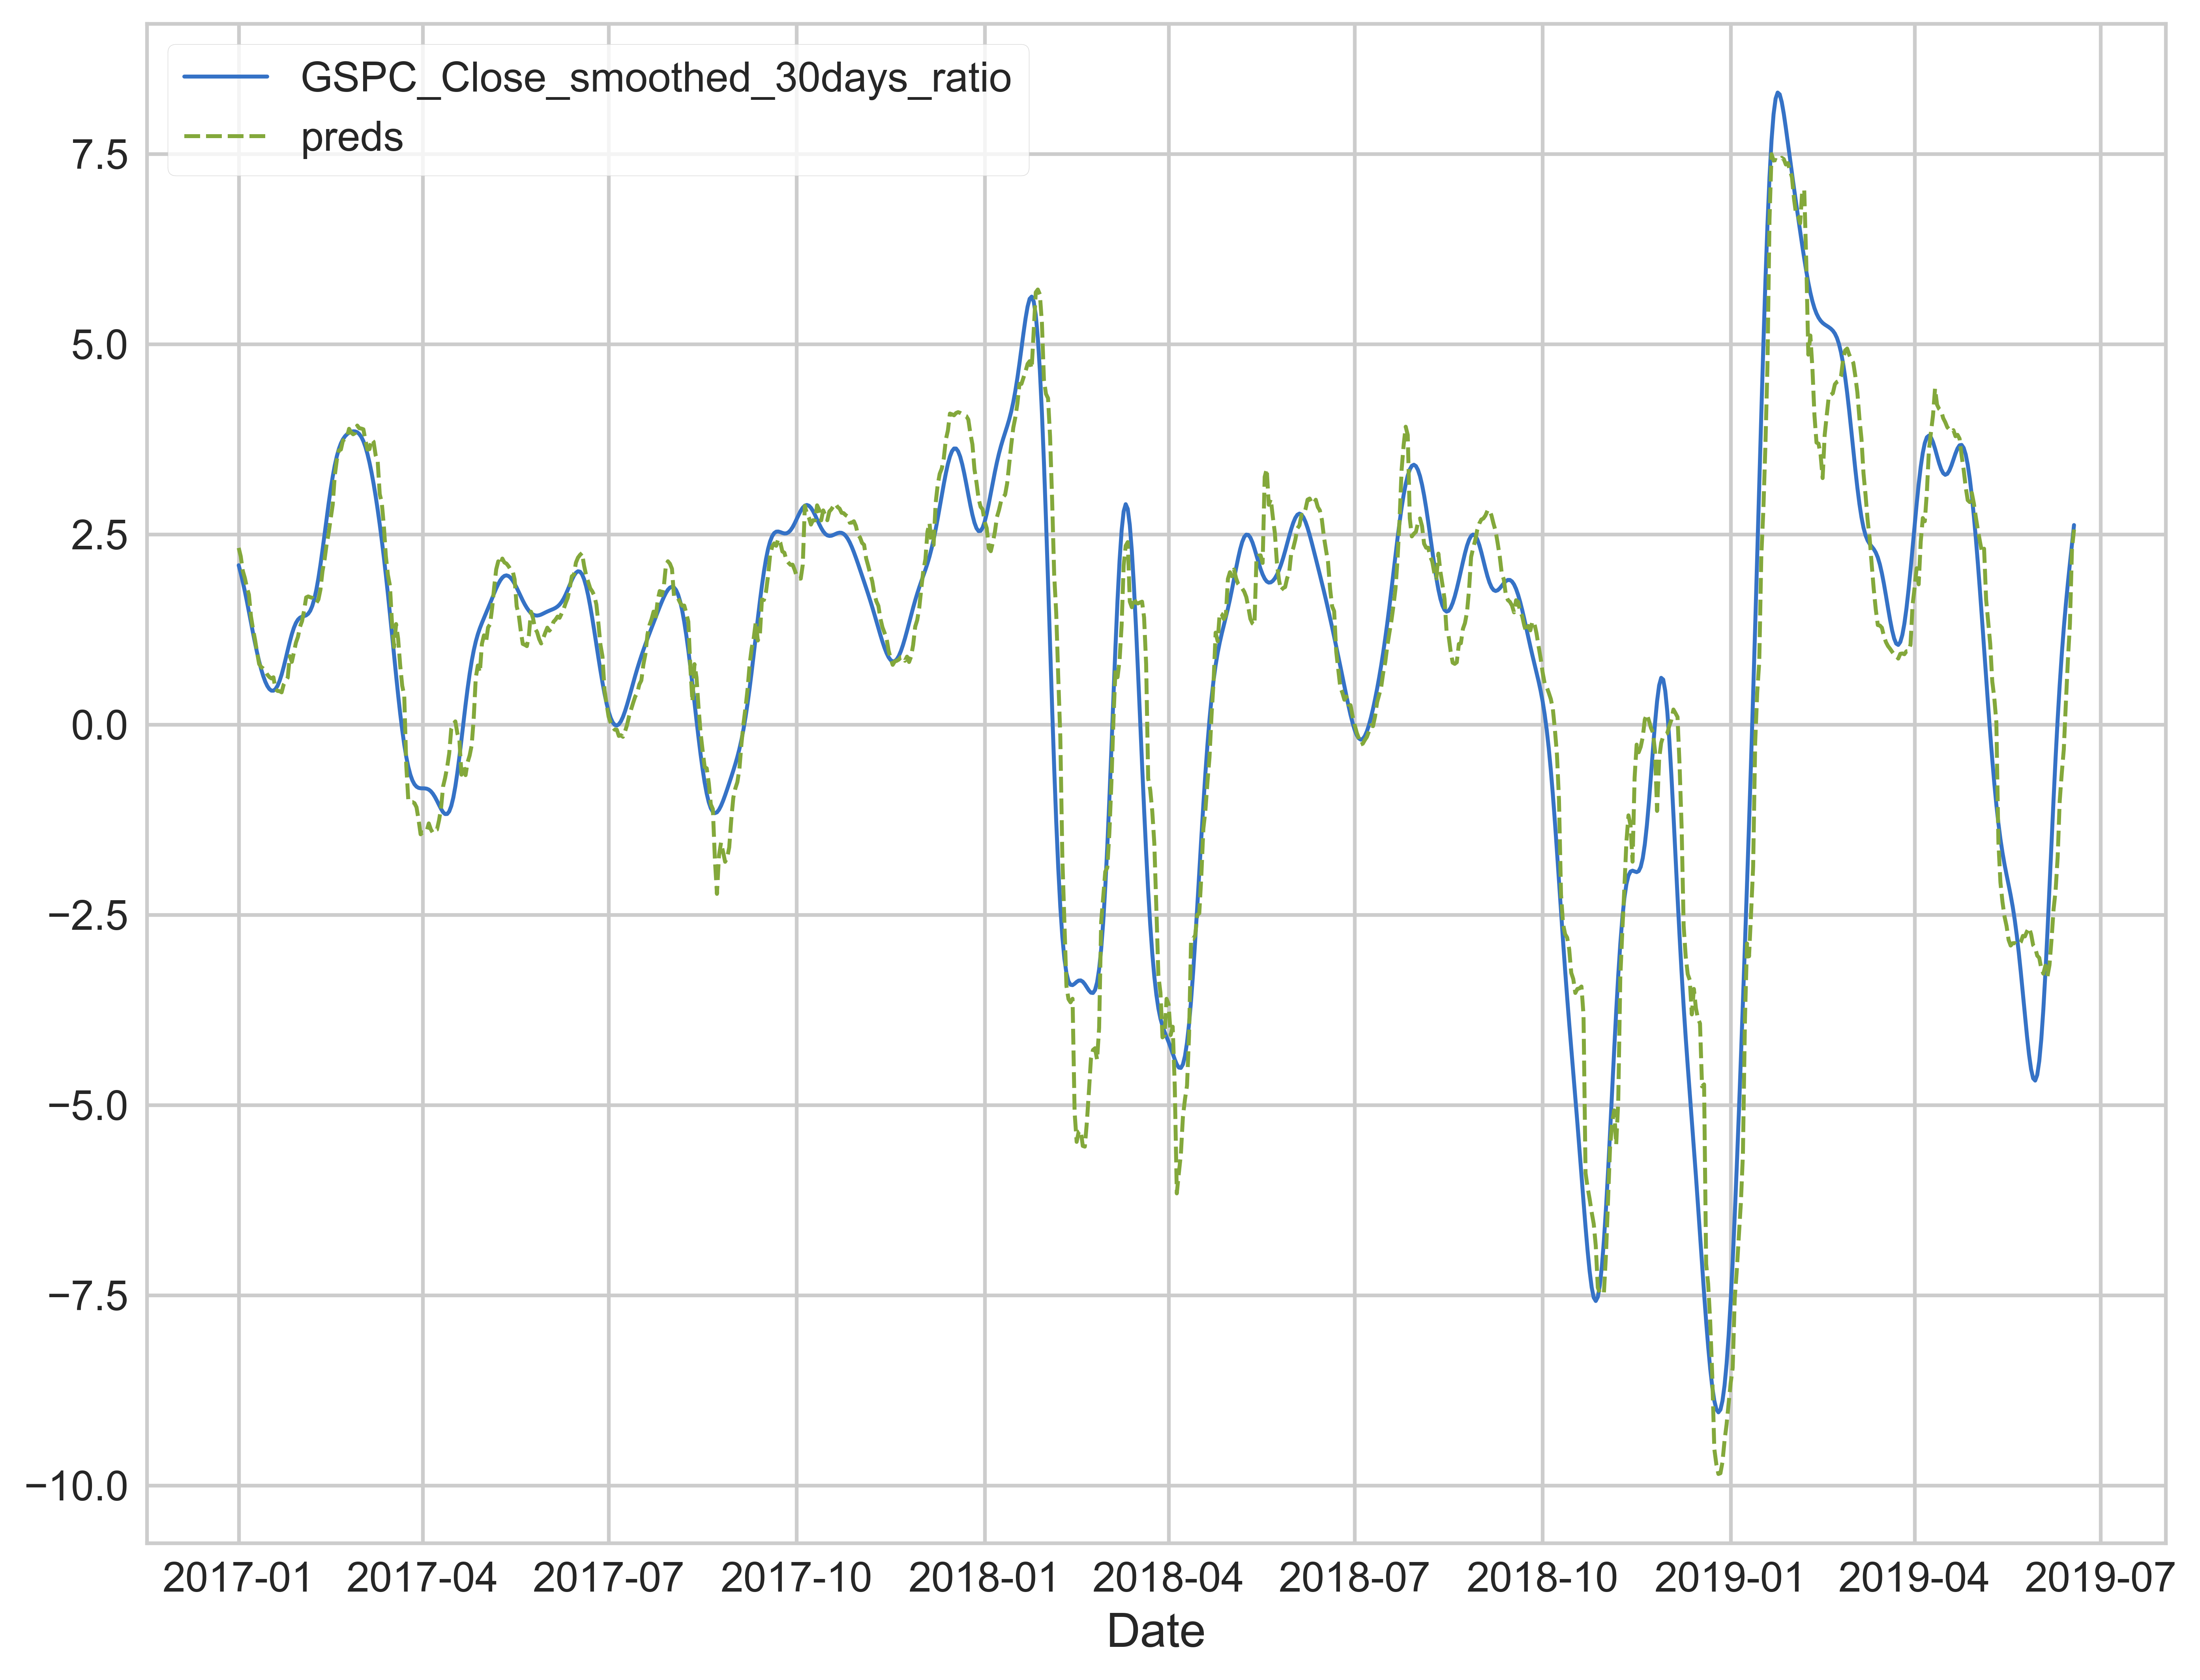

In [16]:

plot_valid_result=valid_result

plot_start_date= pd.to_datetime('2017-01-01')
plot_end_date= pd.to_datetime('2020-01-03')

plot_valid_result=plot_valid_result[plot_valid_result.index>=plot_start_date]
plot_valid_result=plot_valid_result[plot_valid_result.index<=plot_end_date]

    

sns.set_style("whitegrid")

plt.figure(figsize=(11,8.5), dpi=600)

sns.lineplot(data=plot_valid_result)


The absolut error is 0.588%
The custom error is 1.016
15.768128045548925


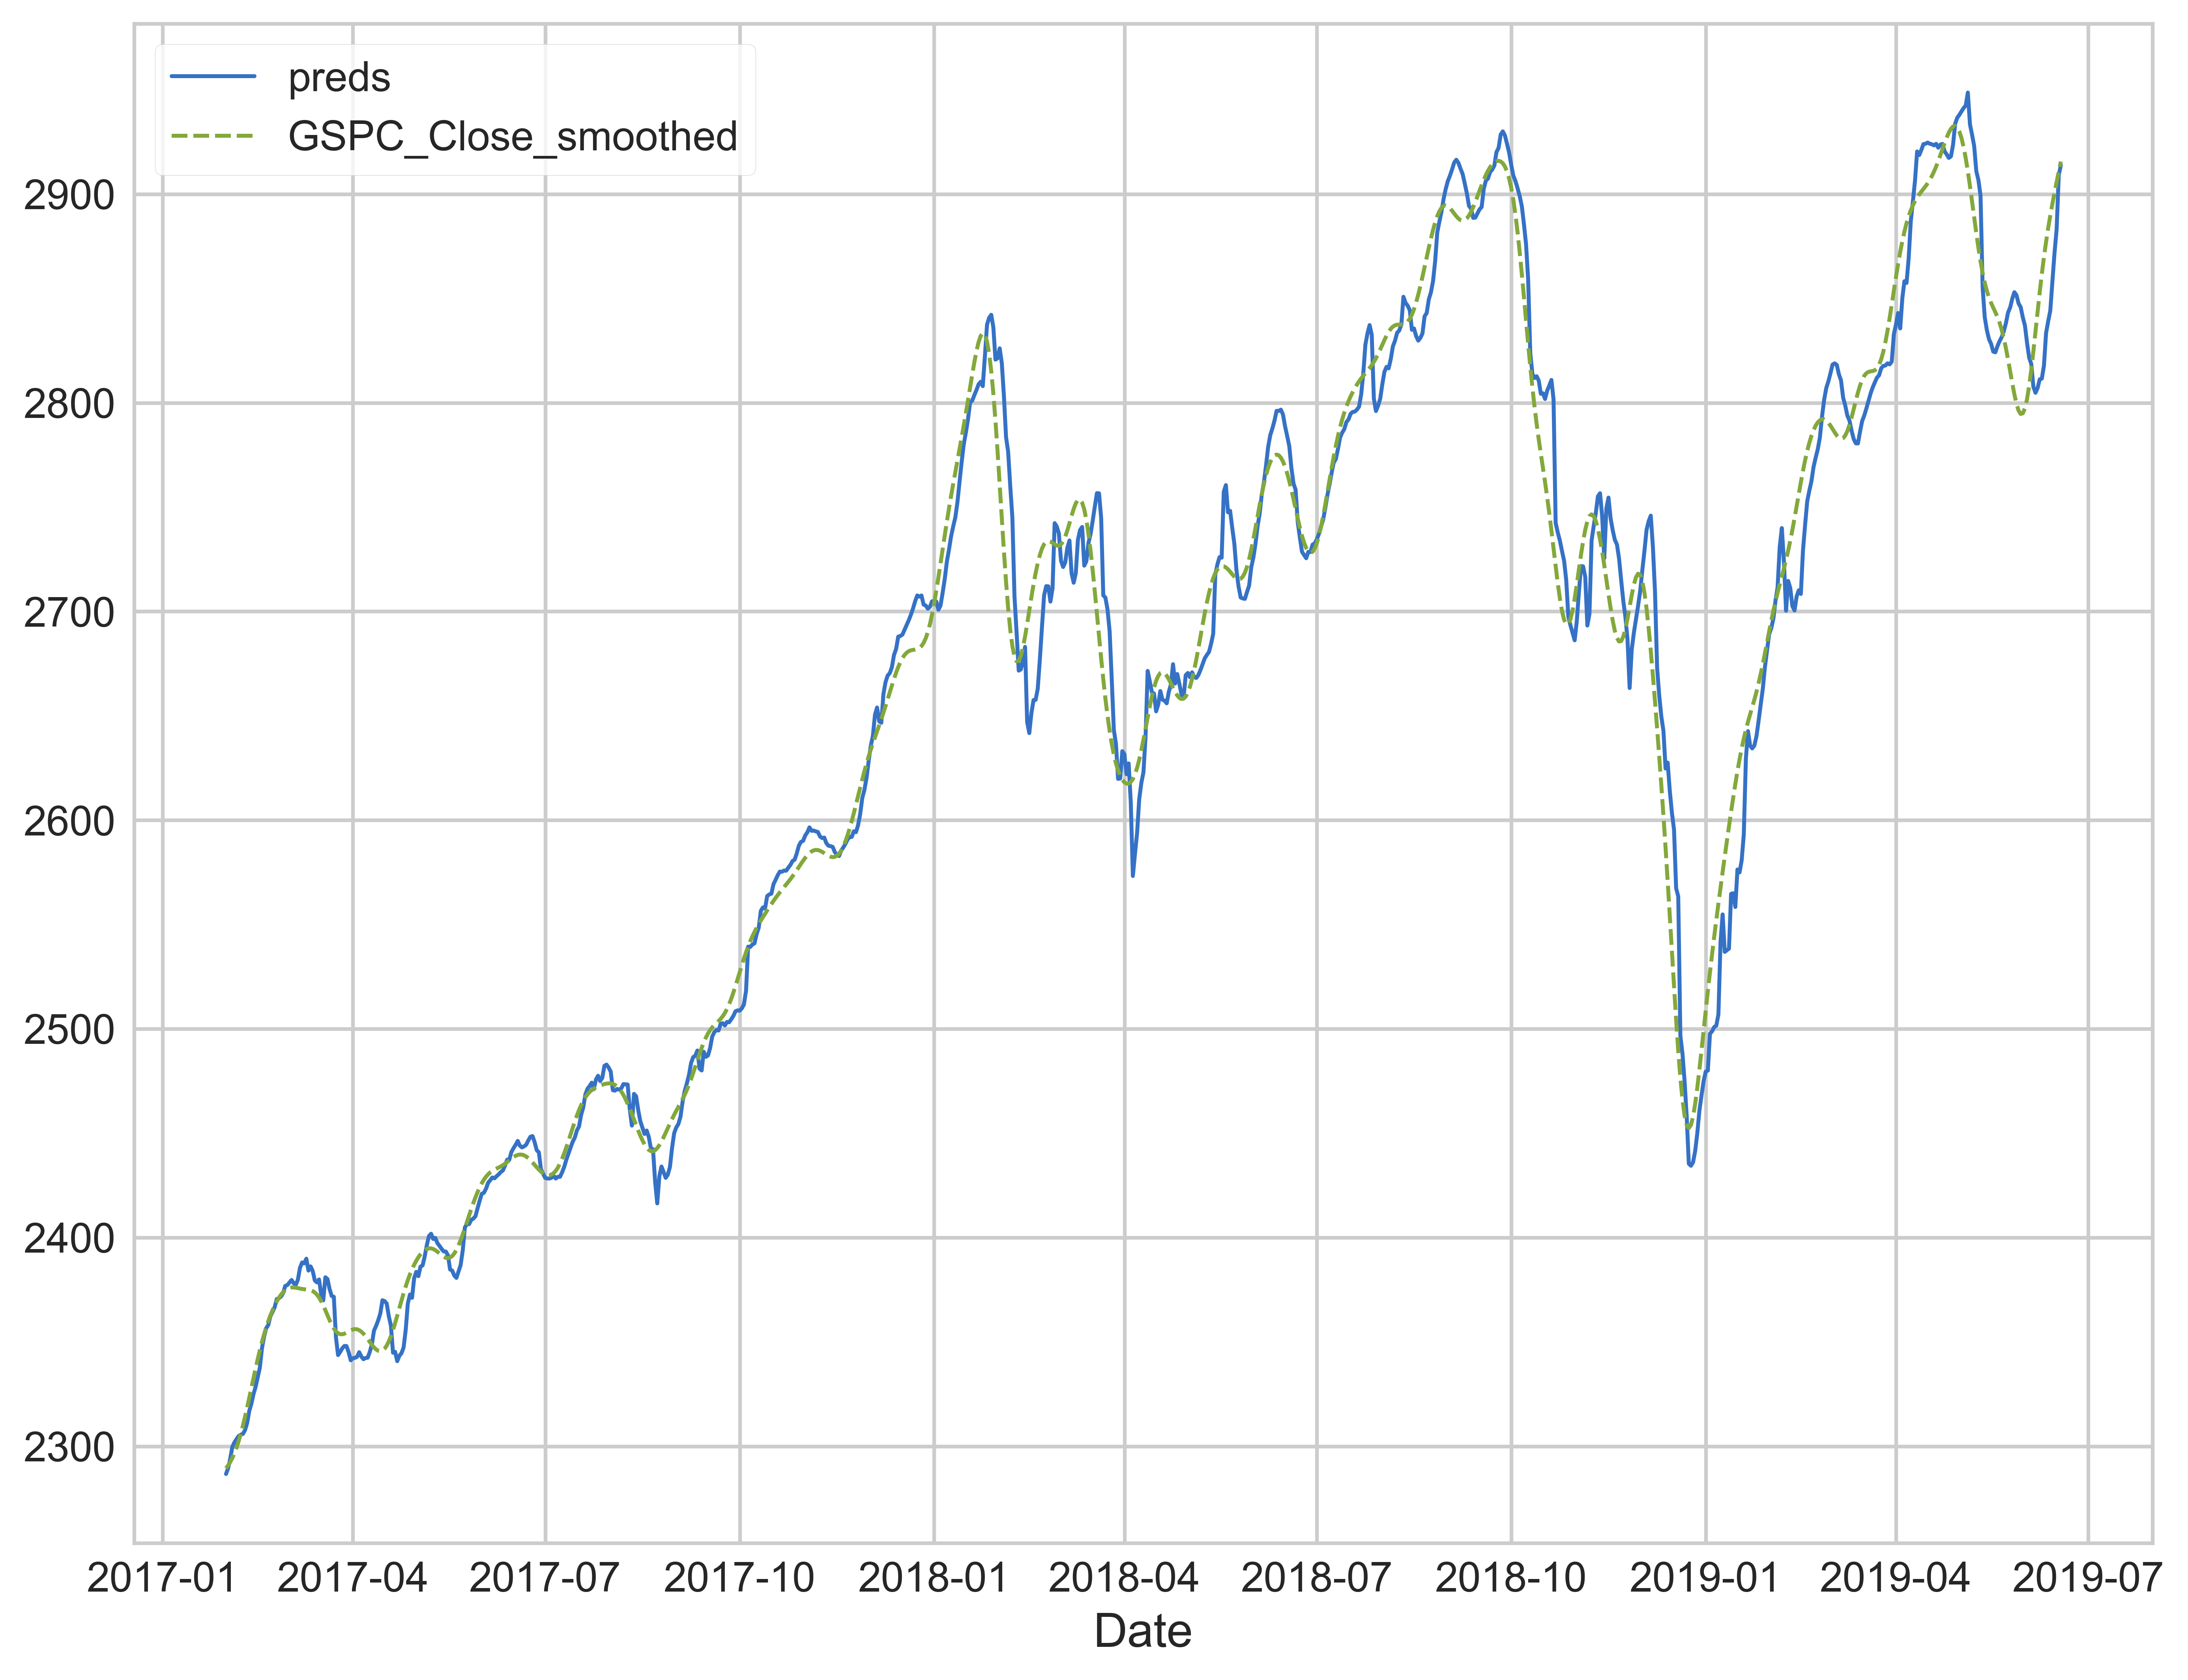

In [17]:
plot_valid_result_new=plot_valid_result.copy()
plot_valid_result_new['GSPC_Close_smoothed']=smooth_data(econ_data_ori,['GSPC_Close'],prediction_distance)['GSPC_Close_smoothed']



plot_valid_result_new['preds']=plot_valid_result_new['GSPC_Close_smoothed'].shift(periods=int(prediction_distance))*(plot_valid_result_new['preds']/100+1)

plot_valid_result_new[target]=plot_valid_result_new['GSPC_Close_smoothed'].shift(periods=int(prediction_distance))*(plot_valid_result_new[target]/100+1)

plot_valid_result_new=plot_valid_result_new.dropna()


sns.set_style("whitegrid")

p_diff_err(plot_valid_result_new[target], plot_valid_result_new['preds'])

diff_err_scorer(plot_valid_result_new[target], plot_valid_result_new['preds'])

plt.figure(figsize=(11,8.5), dpi=600)


plot_cols=plot_valid_result_new.loc[:, plot_valid_result_new.columns != target]
plot_cols=plot_cols.columns

sns.lineplot(data=plot_valid_result_new.loc[:, plot_cols],hue_order=(['preds']+[ e for e in plot_cols if e is not 'preds' ]))

valid_price_score = mean_absolute_error(plot_valid_result_new[target], plot_valid_result_new['preds'])
print(valid_price_score)



In [18]:
def local_extrema (series, tap=30):
    
#     series=rolling_mean(series,tap)
    series=series.dropna()
    
    index_of_maxima=[]
    index_of_minima=[]
    take_derivative=1
    while take_derivative==1:
        try:
            derivative = trendline(series, tap)*1000
            take_derivative=0
        except:
            pass
        
        
    
    def find_intercept (x):
        arr=x
        if max(arr)>0.02 and min(arr)<-0.02:
            last_val=arr[0]
            last_i=arr.index[0]
            for current_val, i in zip(arr[1:], arr.index[1:]):
                if last_val >0 and current_val <= 0:
                    return (i.value)
                if last_val <0 and current_val >= 0:
                    return (i.value)
                last_val=current_val
                last_i=i
        return float("NaN")

    list_of_values_in_window = []
    extrema=derivative.rolling(tap).apply(find_intercept).dropna()
    
    extrema = pd.to_datetime(list(dict.fromkeys(list(extrema.values))))

    extrema = [extremum for extremum in extrema 
               if abs(1-(series[extremum]/series[(extremum-pd.Timedelta(days=tap/2)):(extremum+pd.Timedelta(days=tap/2))].mean()))>0.003]

    return pd.to_datetime(extrema)


def extrema_shifts (ref_series_extrema,test_series_extrema, exclude_limit=60, soothing_period=15):
    
    def smother (date_series,soothing_period=soothing_period):
        date_series=date_series[pd.notnull(date_series)]
        day_diff=(date_series[1:]-date_series[:-1]).days
        index_days_too_close=[i for i in range(len(day_diff)) if day_diff[i]<=10 ]
        new_series = date_series
        for i in index_days_too_close:
            base_index=i
            while pd.isnull(new_series[base_index]):
                base_index=base_index-1
            new_series.values[base_index]=new_series[base_index]+(new_series[i+1]-new_series[base_index])/2
            new_series.values[i+1]=""
            
#         output=extrema_shifts_days.sort_index(axis=0)
#         output[pandas.notnull(output.values)]
        return new_series[pd.notnull(new_series)]
    ref_series_extrema=smother(ref_series_extrema)
    test_series_extrema=smother(test_series_extrema)
    extrema_shifts_days=pd.Series(dtype='float64')
    
    for extreme_date in ref_series_extrema:
        days_diff=([(extreme_date - test_extreme) for test_extreme in test_series_extrema])
        lowest_diff=days_diff[0]
#         print(days_diff)
        for diff in days_diff:
            if abs(diff)<abs(lowest_diff):
                lowest_diff=diff
        if abs(lowest_diff)<=pd.Timedelta(exclude_limit,'D'):
            extrema_shifts_days.at[extreme_date]=lowest_diff

    return extrema_shifts_days.sort_index(axis=0).dropna()


In [19]:
a=local_extrema(plot_valid_result_new['preds'])
# print(a)
b=local_extrema(plot_valid_result_new[target])
# print(b)
c= extrema_shifts (b,a)
print(c)
print('Average extrema shift = ' + str(c.mean()/pd.to_timedelta(1, unit='D').days))

2017-07-03    -3 days +00:00:00
2018-02-05    -4 days +00:00:00
2018-04-18     44 days 00:00:00
2018-06-28      0 days 00:00:00
2018-07-12     14 days 00:00:00
2018-10-07   -48 days +12:00:00
2018-11-22    -2 days +12:00:00
2019-01-10     47 days 12:00:00
2019-06-12    -4 days +00:00:00
dtype: timedelta64[ns]
Average extrema shift = 5 days 01:20:00


In [20]:

dtrain = lgb.Dataset(train[feature_cols], label=train[target])
dvalid = lgb.Dataset(valid[feature_cols], label=valid[target])

param = {'num_leaves': 5, 
         'learning_rate':0.001,
#          'num_iterations':1000,
         'min_data_in_leaf':10,
#          'boosting' : 'dart',
         'max_bin' : 87}
param['metric'] = 'regression_l1'
num_round = 1000
bst = lgb.train(param, dtrain, num_round, valid_sets=[dvalid], early_stopping_rounds=50, verbose_eval=False)

from sklearn import metrics
ypred = bst.predict(test[feature_cols])
score = metrics.mean_absolute_error(test[target], ypred)

print(f"Test MAE score: {score}")

score=[]



[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2436
[LightGBM] [Info] Number of data points in the train set: 9966, number of used features: 28
[LightGBM] [Info] Start training from score 0.707672
Test MAE score: 1.2383659034517362


<AxesSubplot:xlabel='Date'>

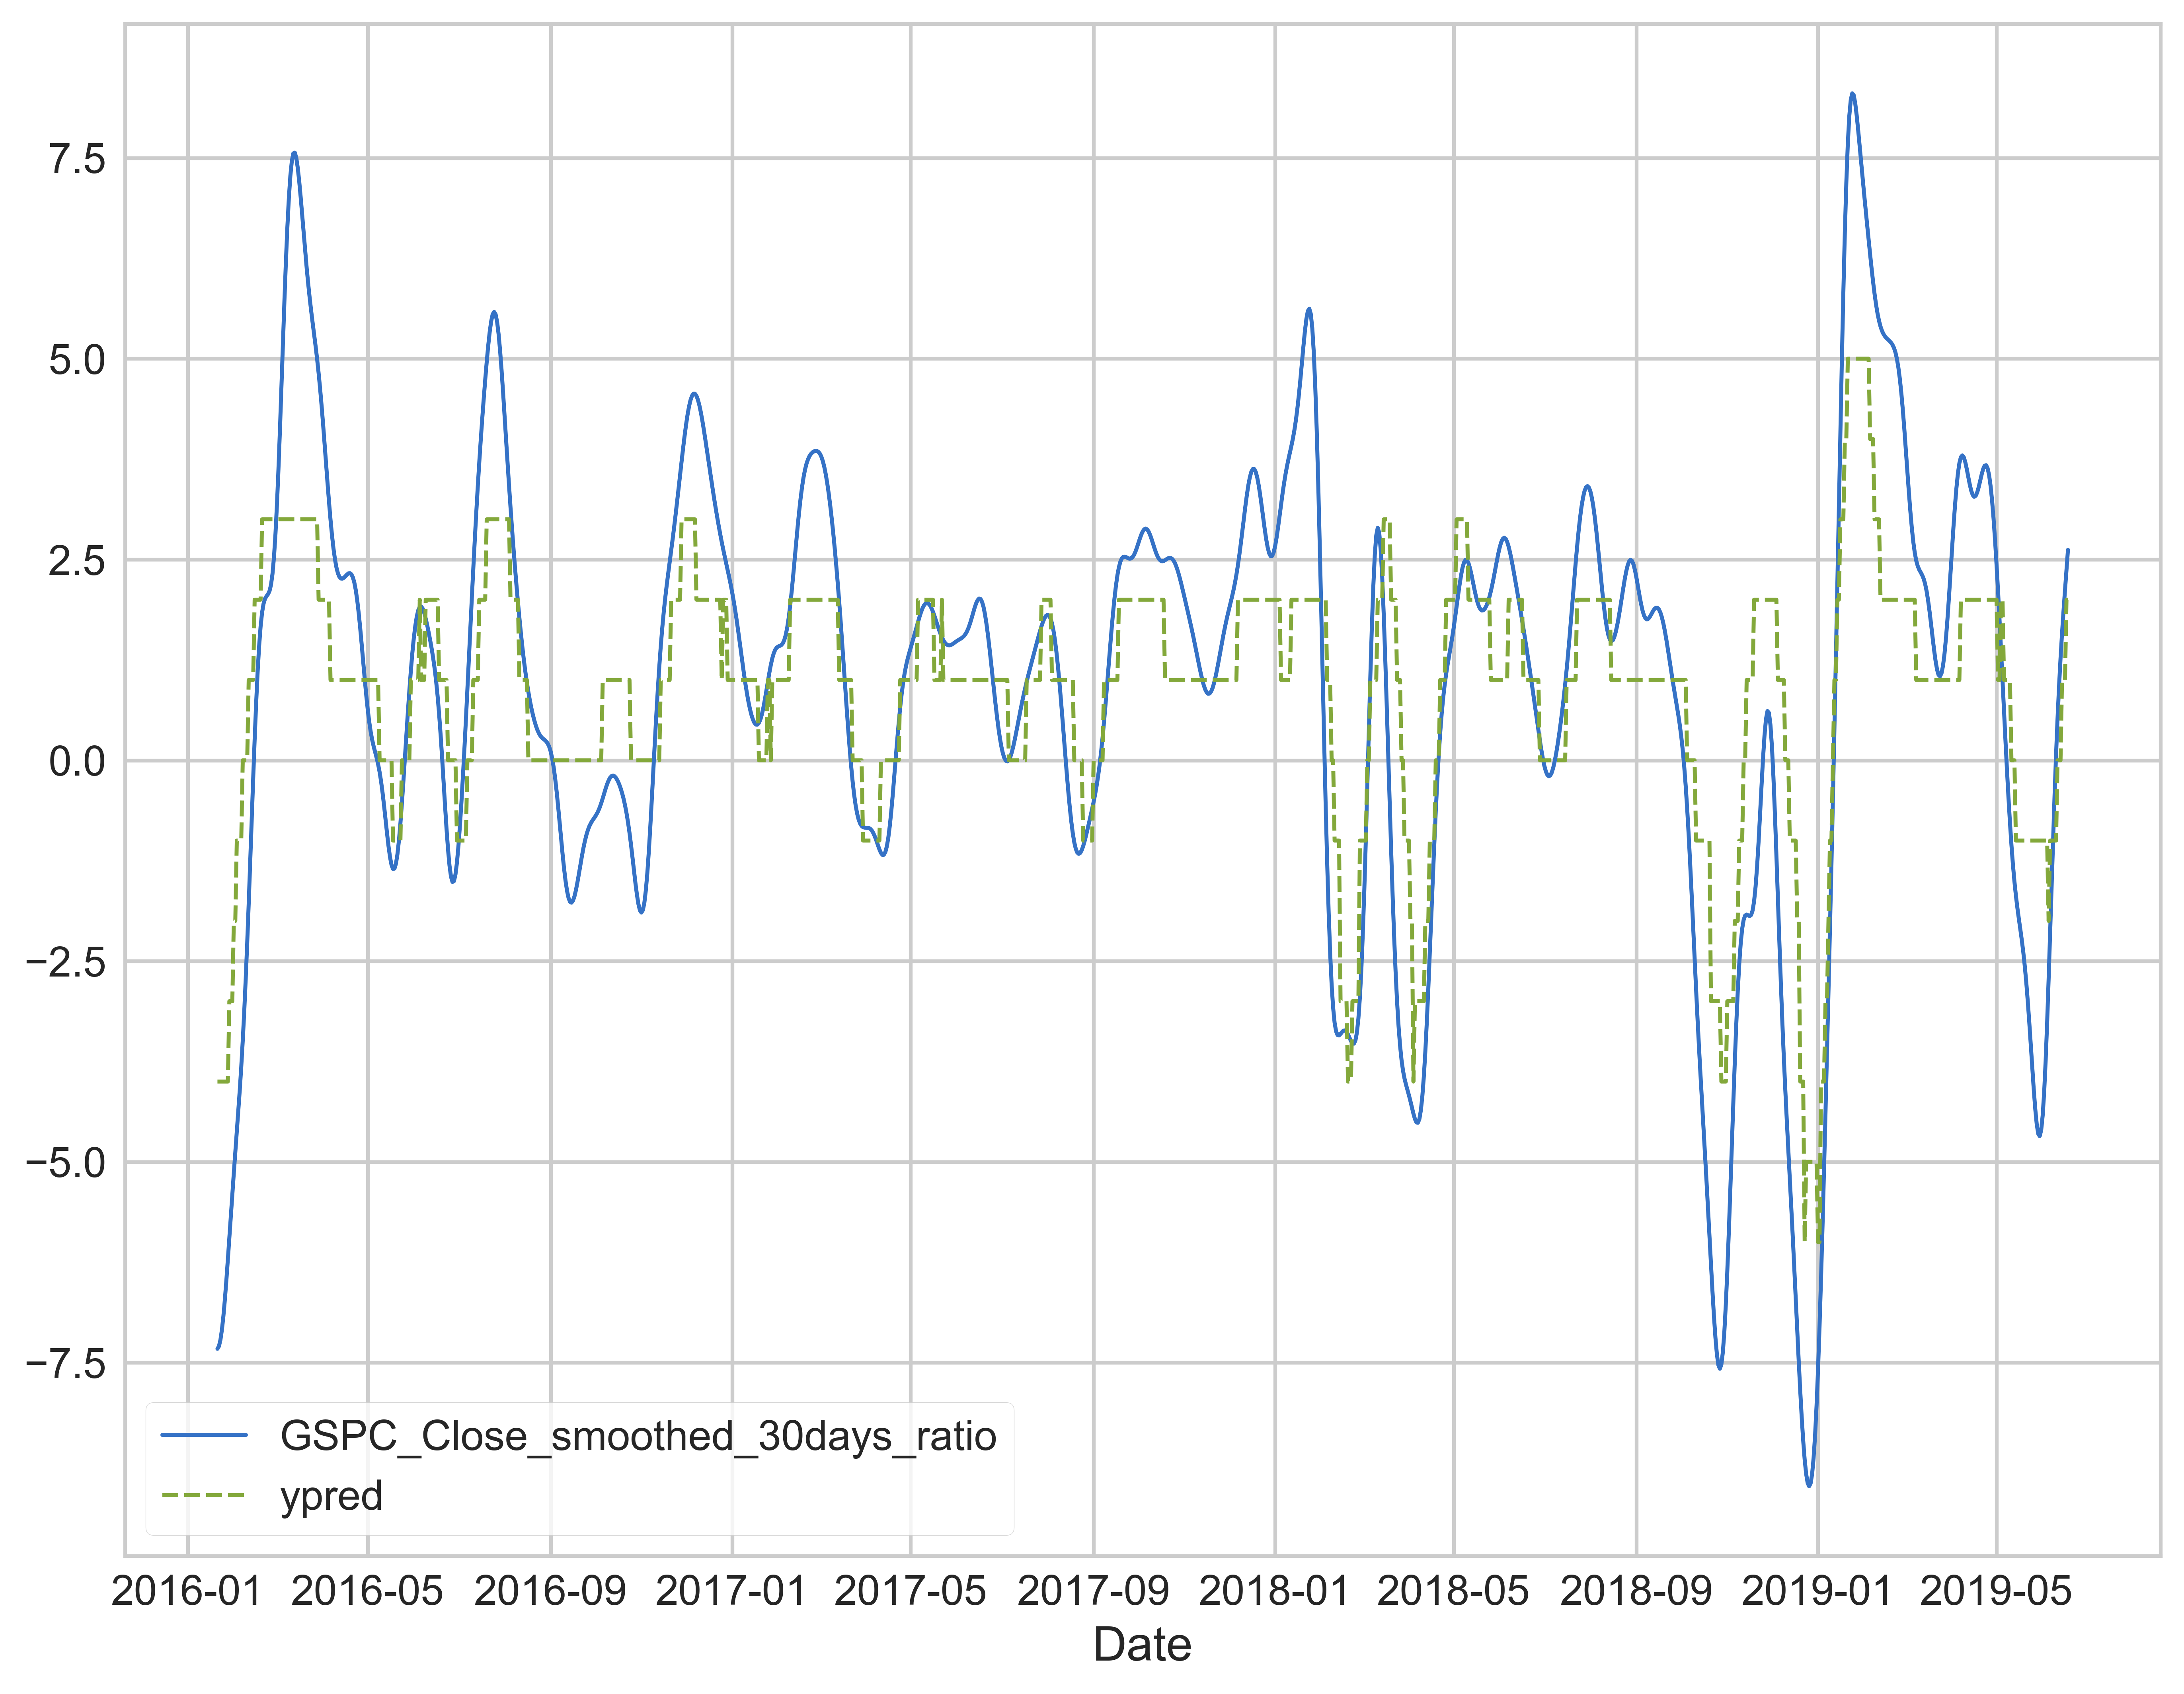

In [21]:
test_result=test[target].to_frame()
test_result['ypred']=ypred

# plt.figure(figsize=(11,8.5), dpi=600)
# sns.lineplot(data=test_result)

plot_test_result=test_result
plot_test_result['ypred']=(plot_test_result['ypred']).apply(round)

plot_start_date= pd.to_datetime('2010-10-01')
plot_end_date= pd.to_datetime('2020-01-03')

plot_test_result=test_result[plot_test_result.index>=plot_start_date]
plot_test_result=plot_test_result[plot_test_result.index<=plot_end_date]

sns.set_style("whitegrid")

plt.figure(figsize=(11,8.5), dpi=600)

sns.lineplot(data=plot_test_result)


The absolut error is 1.238%
The custom error is 2.851


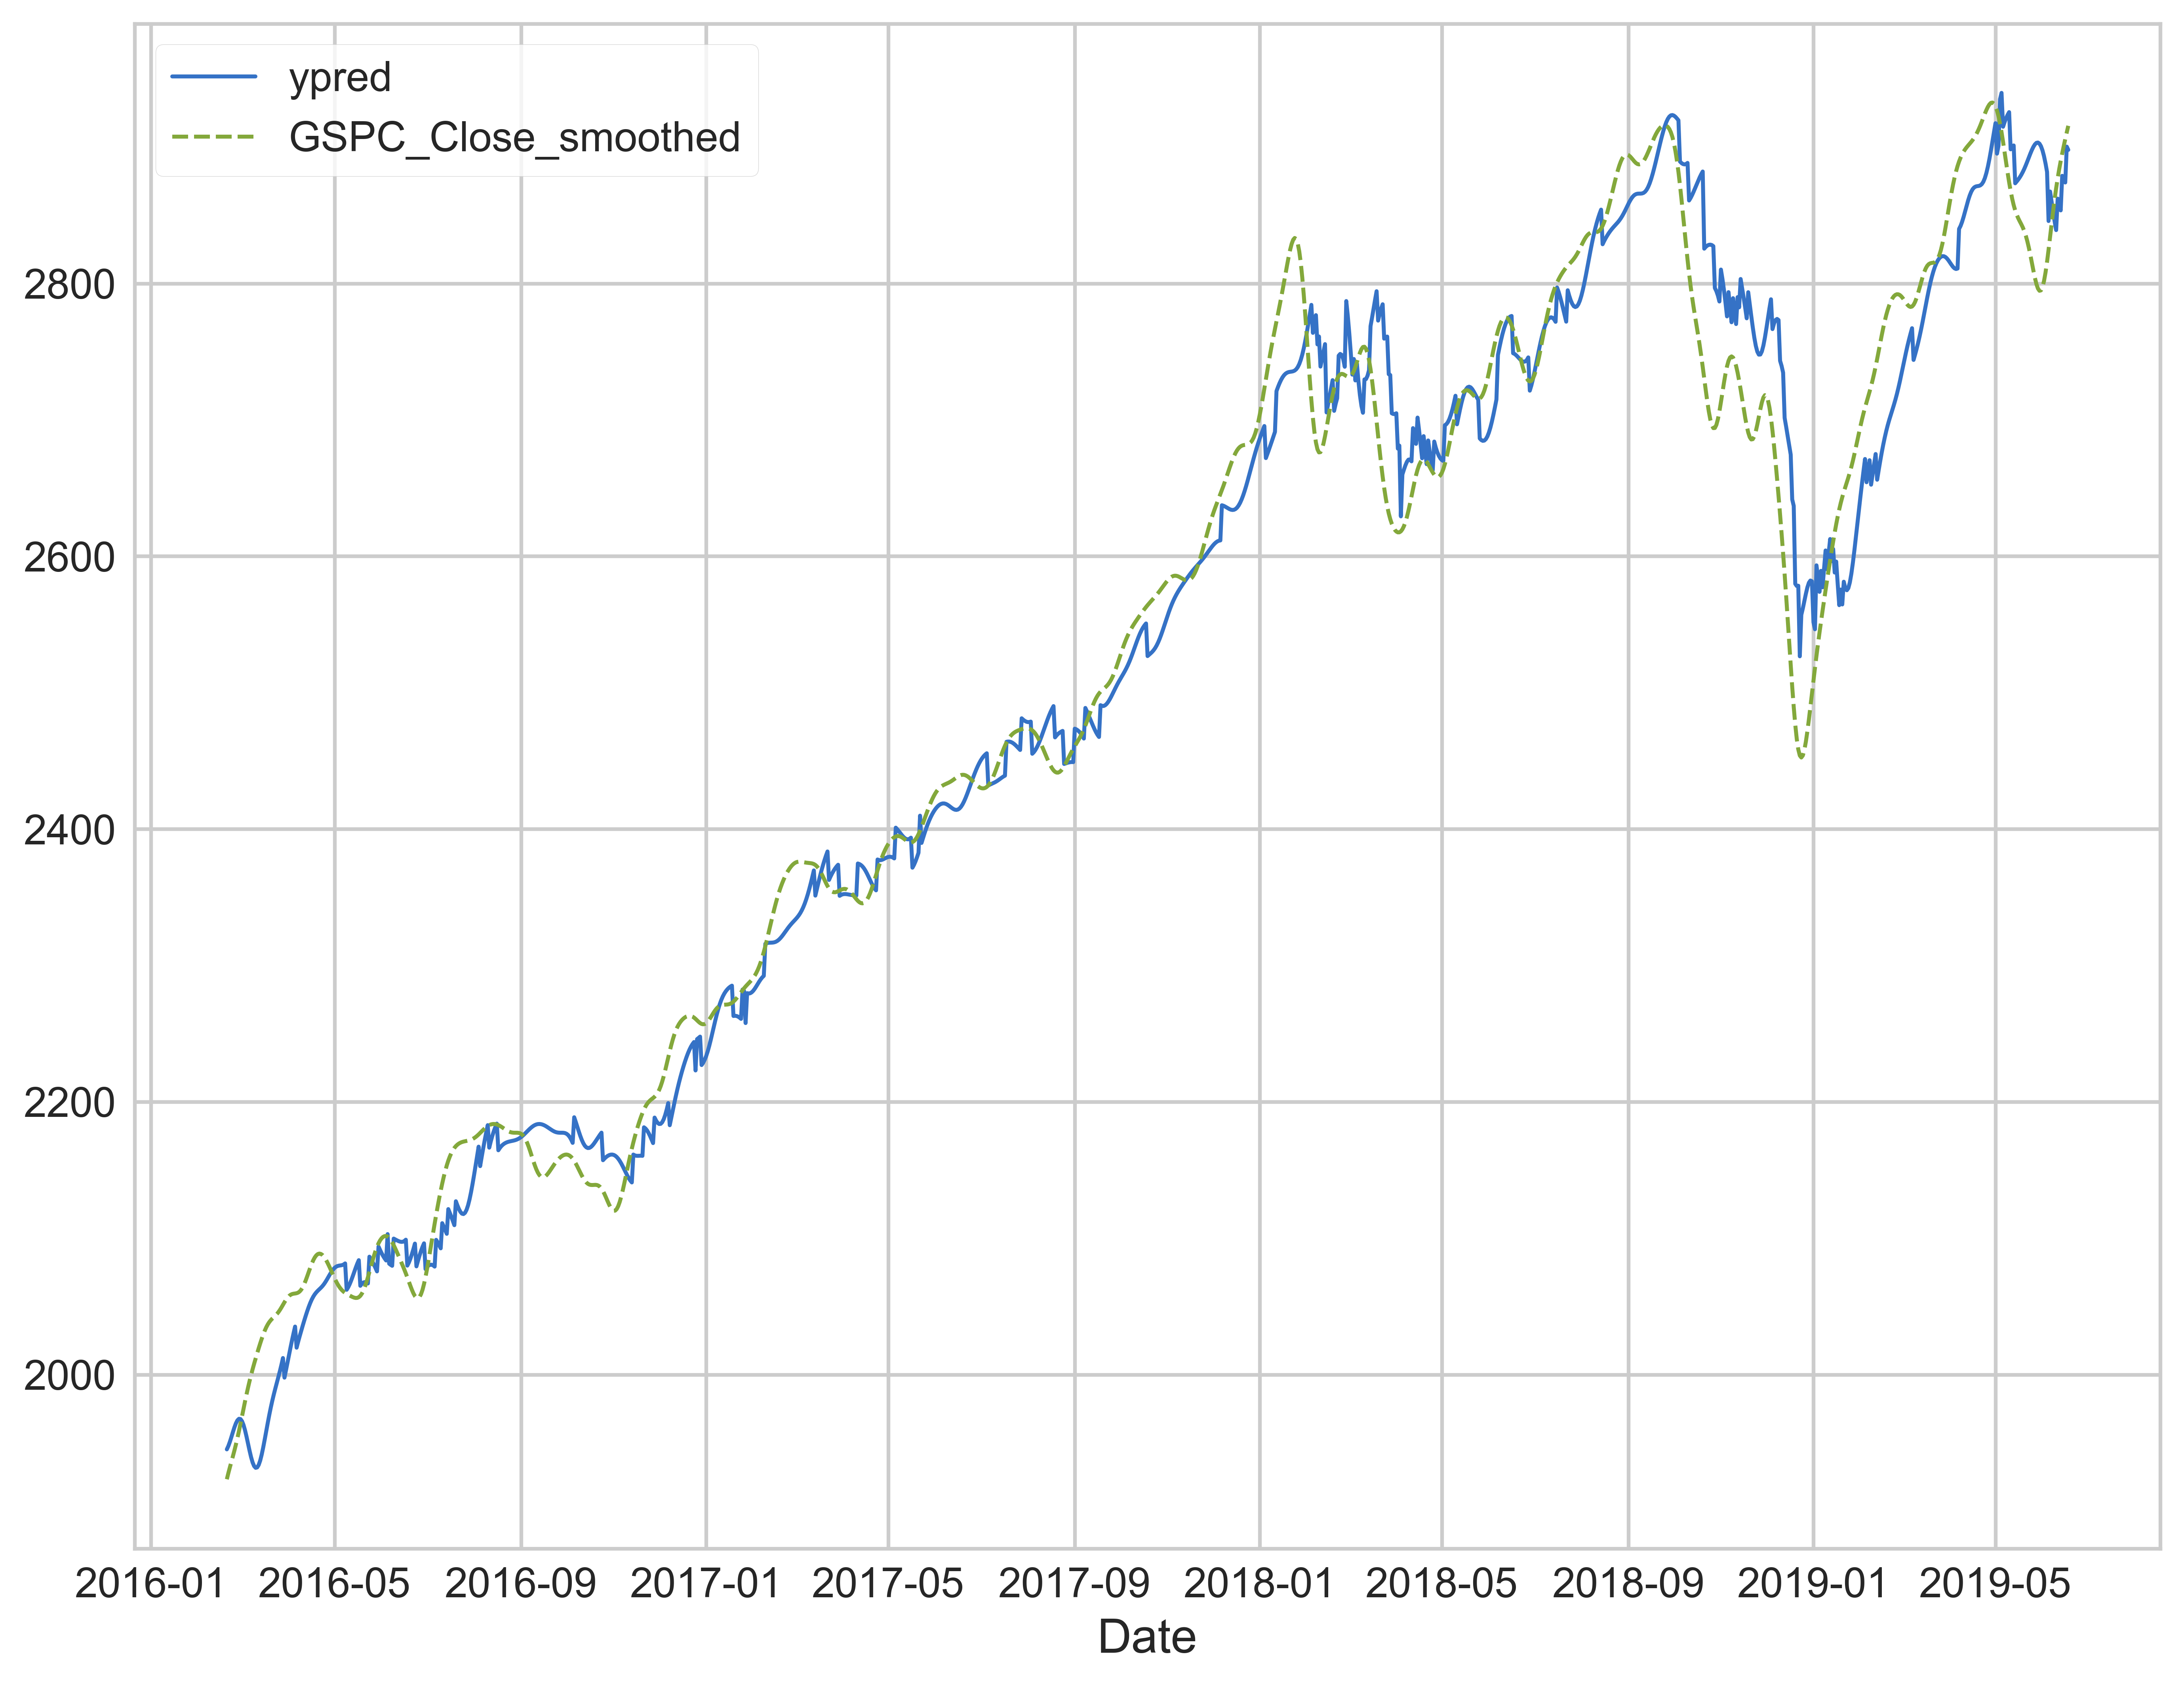

31.274072128336382


In [22]:
plot_test_result_new=plot_test_result.copy()
plot_test_result_new['GSPC_Close_smoothed']=smooth_data(econ_data_ori,['GSPC_Close'],prediction_distance)['GSPC_Close_smoothed']

# plot_test_result_new['preds']=plot_test_result_new['preds']*plot_test_result_new['GSPC_Close_30days_ratio'].shift(periods=-1)

# rolling_30days_prod=(10**(np.log10(plot_valid_result['preds']/100+1)/30)).rolling(30).apply(np.prod)
# plot_test_result_new['preds']=plot_test_result_new['GSPC_Close_60days_ratio'].shift(periods=30)*rolling_30days_prod


plot_test_result_new['ypred']=plot_test_result_new['GSPC_Close_smoothed'].shift(periods=int(prediction_distance))*(plot_test_result_new['ypred']/100+1)
# plot_test_result_new['preds_smoothed']=smooth_data(plot_test_result_new,['preds'])['preds_smoothed']
plot_test_result_new[target]=plot_test_result_new['GSPC_Close_smoothed'].shift(periods=int(prediction_distance))*(plot_test_result_new[target]/100+1)

plot_test_result_new=plot_test_result_new.dropna()

sns.set_style("whitegrid")

p_diff_err(plot_test_result_new[target], plot_test_result_new['ypred'])

diff_err_scorer(plot_test_result_new[target], plot_test_result_new['ypred'])

plt.figure(figsize=(11,8.5), dpi=600)

sns.lineplot(data=plot_test_result_new.loc[:, plot_test_result_new.columns != target])
plt.show()

valid_price_score = mean_absolute_error(plot_test_result_new[target], plot_test_result_new['ypred'])
print(valid_price_score)

In [23]:
# a=local_extrema(plot_test_result_new['ypred']/1500)

# b=local_extrema(plot_test_result_new[target]/1500)

a=local_extrema(plot_test_result_new['ypred']/1500)

b=local_extrema(plot_test_result_new[target]/1500)

c= extrema_shifts (b,a)
print(c)
print('Average extrema shift = ' + str(c.mean()/pd.to_timedelta(1, unit='D').days))

2016-05-07   -19 days
2016-05-27     1 days
2016-06-20   -10 days
2016-10-04   -49 days
2017-07-03   -53 days
2018-02-05   -12 days
2018-04-18   -11 days
2018-06-28    -5 days
2018-07-12     9 days
2018-10-07    -6 days
2018-11-22    40 days
2019-01-10    -6 days
dtype: timedelta64[ns]
Average extrema shift = -11 days +22:00:00


In [24]:
my_model = XGBRegressor(n_estimators=999, learning_rate=0.01, n_jobs=8,tree_method='exact',min_child_weight=1,subsample=0.5)
my_model.fit(X_train, y_train, 
             early_stopping_rounds=10, 
             eval_set=[(X_valid, y_valid)], 
             verbose=False,
             eval_metric = "mae",
             
             )

predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 0.49316961982622454


                                                       0
DJI_Close_smoothed_30d_30days_1order_extrapolated    310
us_unemp_UNRATE_smoothed_30d_30days_1order_extr...   337
DJI_Close_smoothed_30d_30days_2order_extrapolated    346
GSPC_Close_smoothed_30d_30days_1order_extrapolated   356
N225_Close_smoothed_30days_trendline_30d             426
N225_Close_smoothed_30days_ratio_30days_trendli...   471
N225_Close_smoothed_30d_30days_1order_extrapolated   478
DJI_Close_smoothed_30days_trendline_30d              488
N225_Close_smoothed_30d_30days_2order_extrapolated   505
us_unemp_UNRATE_smoothed_30d_30days_2order_extr...   524
N225_Close_smoothed_30days_ratio_30d_30days_1or...   532
N225_Close_smoothed_30days_ratio_30d_30days_2or...   578
DJI_Close_smoothed_30days_ratio_30days_trendlin...   603
DJI_Close_smoothed_30d                               661
DJI_Close_smoothed_30days_ratio_30d                  662
DJI_Close_smoothed_30days_ratio_30d_30days_1ord...   672
GSPC_Close_smoothed_30days_rati

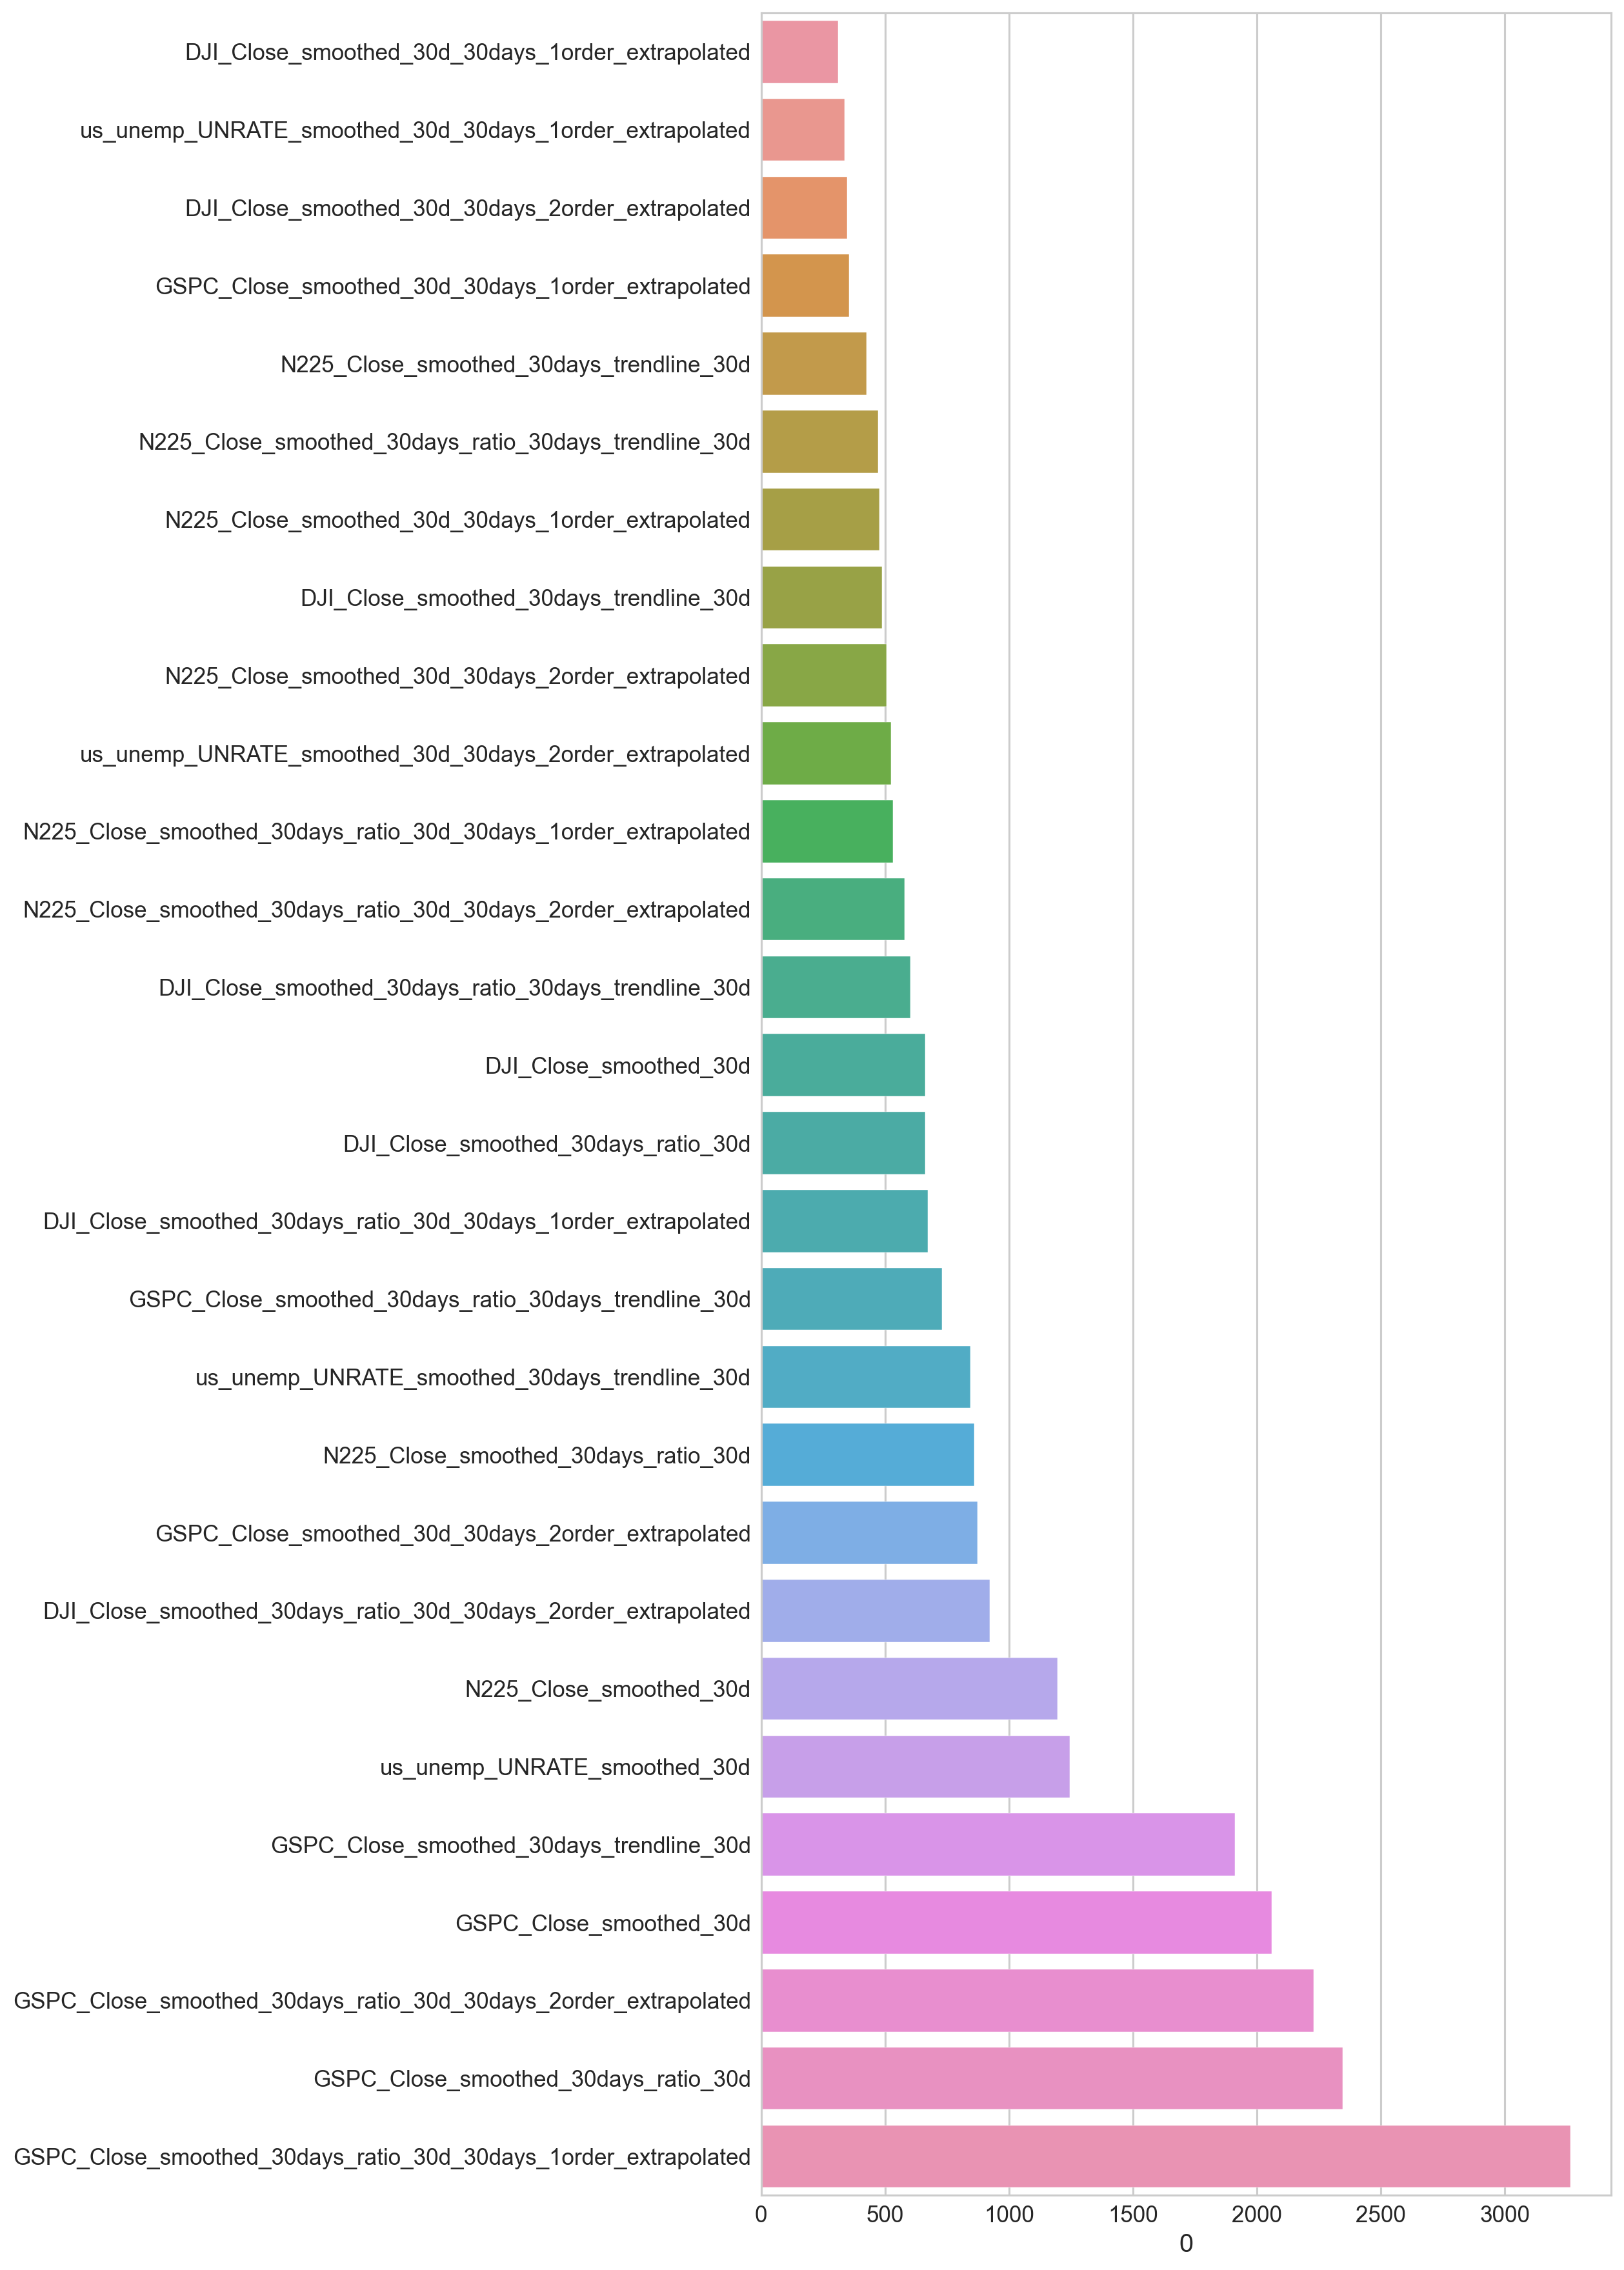

In [25]:
f_score=my_model.get_booster().get_fscore()
keys = list(f_score.keys())
values = list(f_score.values())

feat_rank=pd.DataFrame(data=values, index=keys).sort_values(by=0)
# feat_rank=np.log10((quick_model.feature_importances_)/max(quick_model.feature_importances_)*1e7)
plt.figure(figsize=(8.5,0.8*len(list(X_train.columns))), dpi=200)
# pd_series = pd.Series(data=feat_rank).sort_values()
sns.barplot(y=feat_rank.index, x=feat_rank[0])
print(feat_rank)
# bst.get_fscore()
# fscore = fimp_xgb_model.booster().get_fscore()

<AxesSubplot:xlabel='Date'>

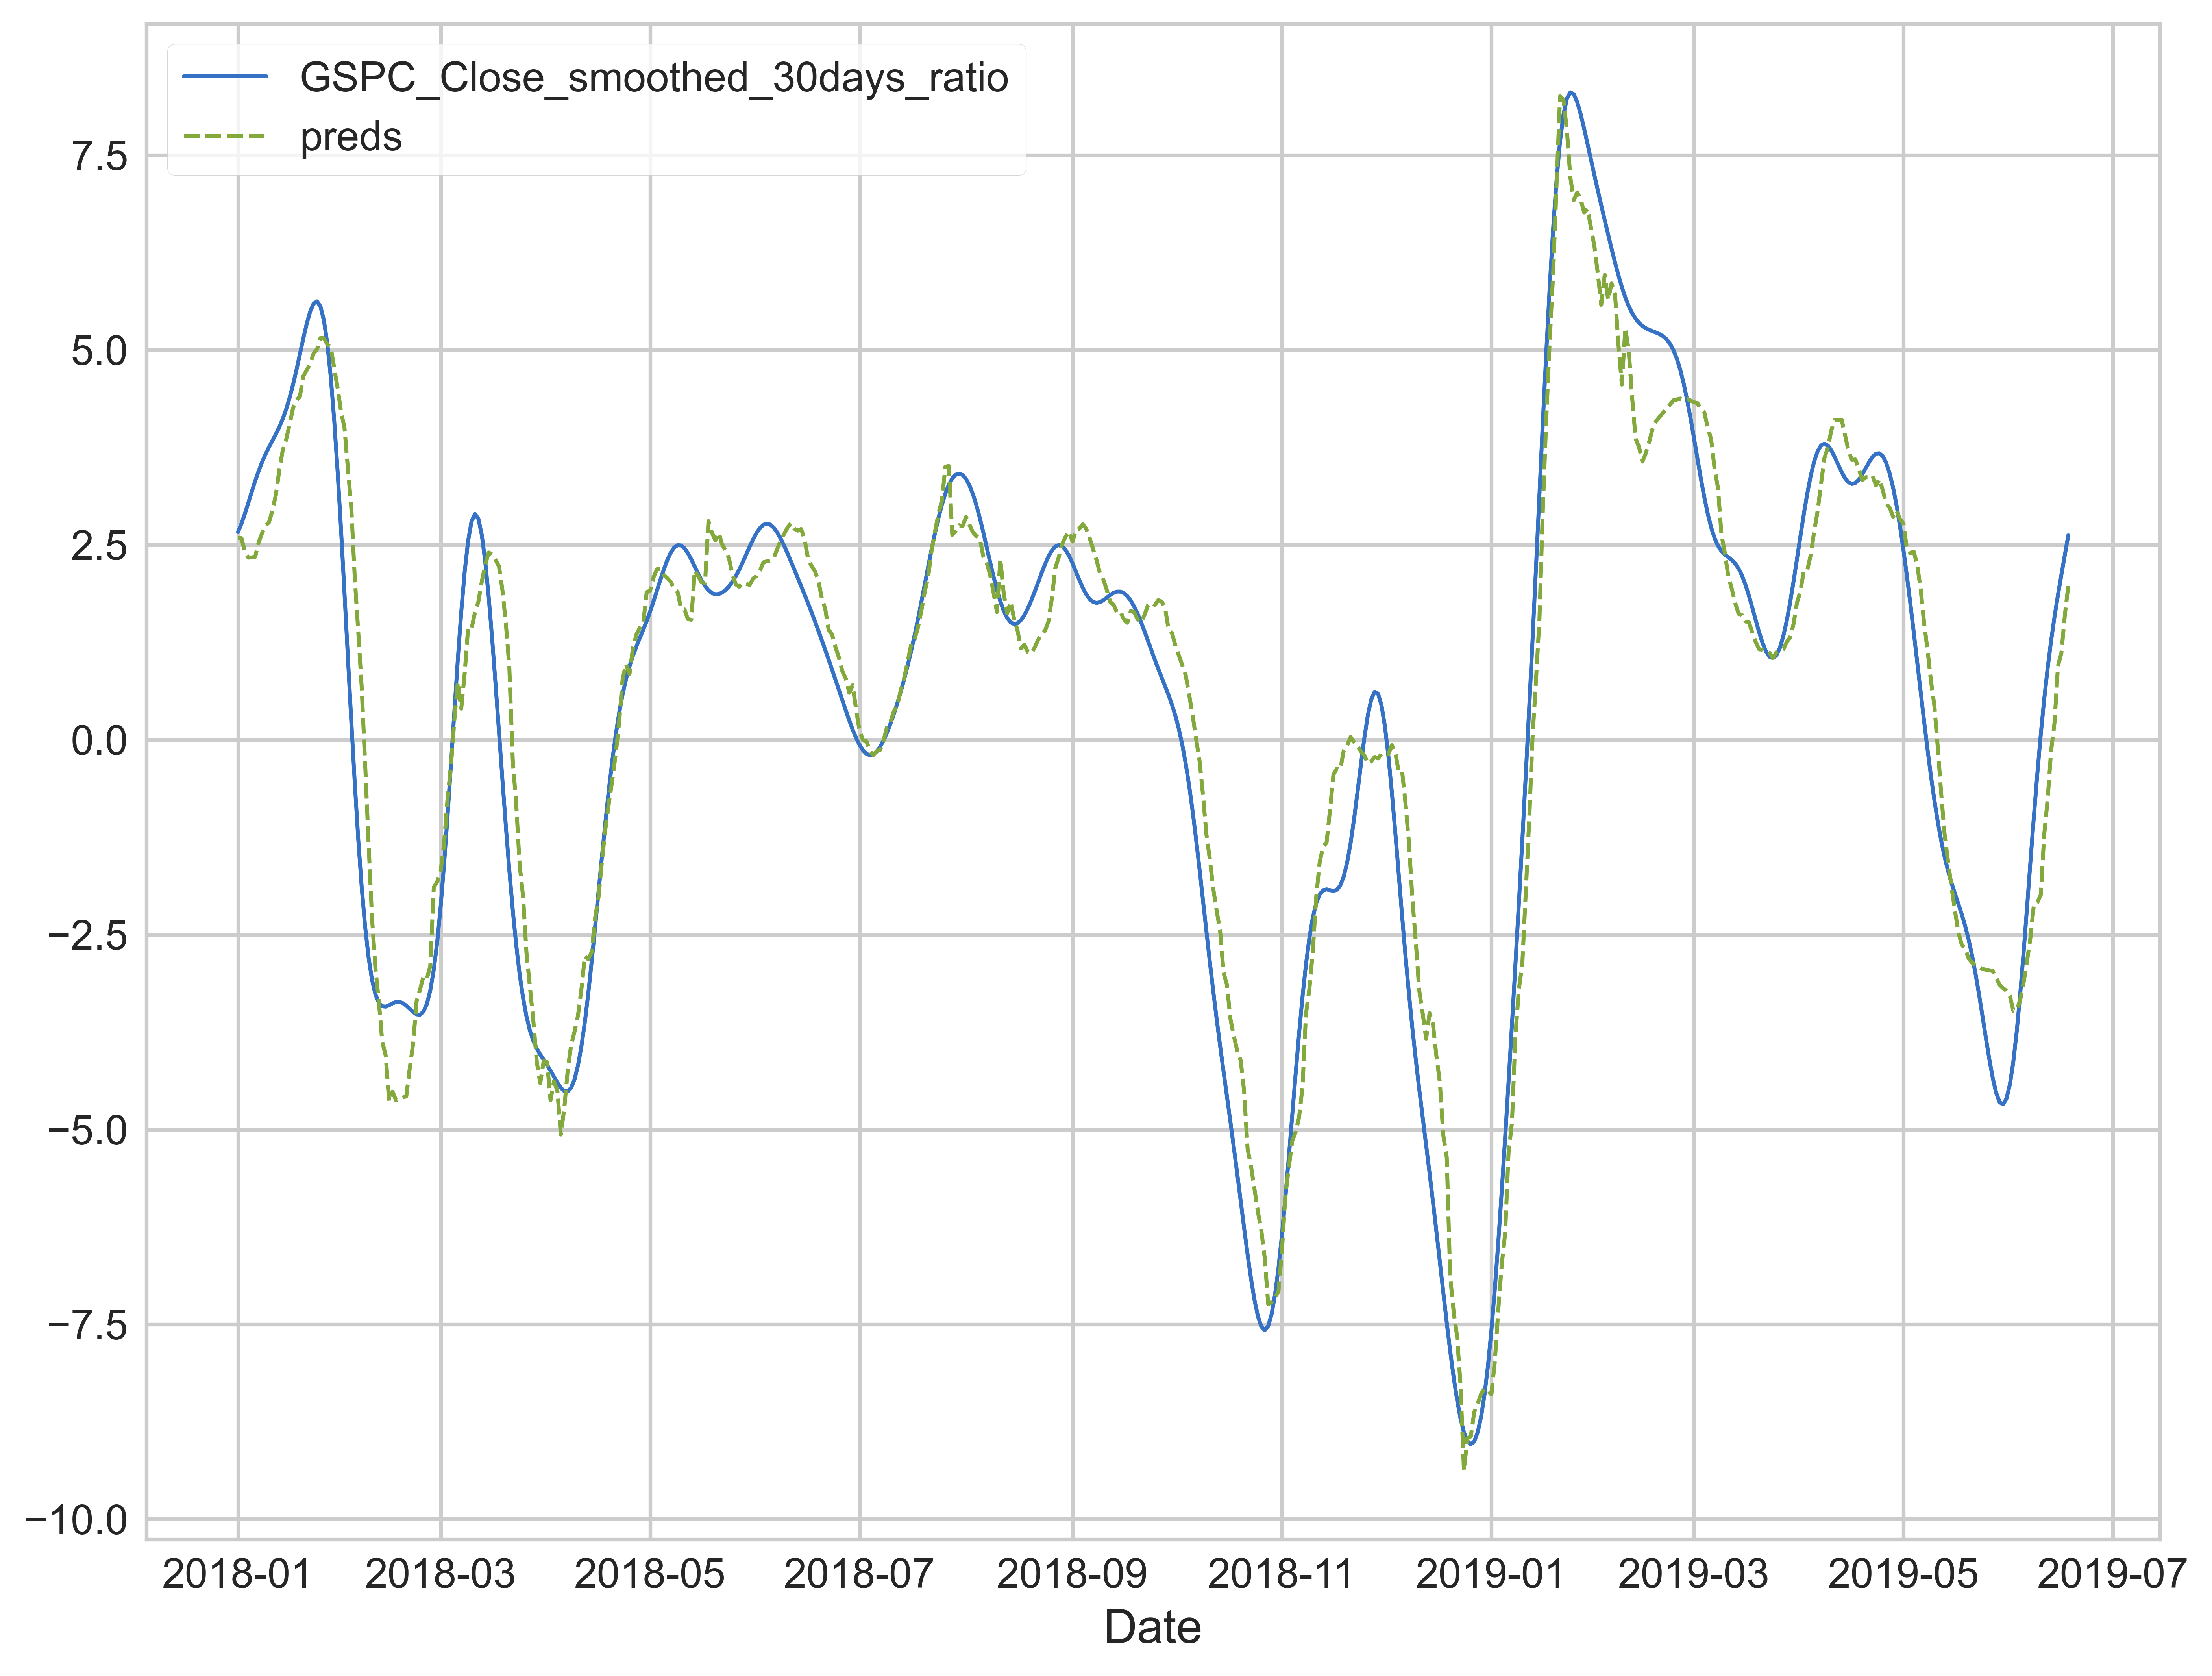

In [26]:
XGBvalid_result=y_valid.to_frame()
XGBvalid_result['preds']=predictions

plot_XGBvalid_result=XGBvalid_result


plot_start_date= pd.to_datetime('2018-1-1')
plot_end_date= pd.to_datetime('2019-12-1')

plot_XGBvalid_result=XGBvalid_result[plot_XGBvalid_result.index>=plot_start_date]
plot_XGBvalid_result=plot_XGBvalid_result[plot_XGBvalid_result.index<=plot_end_date]

sns.set_style("whitegrid")

plt.figure(figsize=(11,8.5), dpi=600)

sns.lineplot(data=plot_XGBvalid_result)




The absolut error is 0.695%
The custom error is 1.123


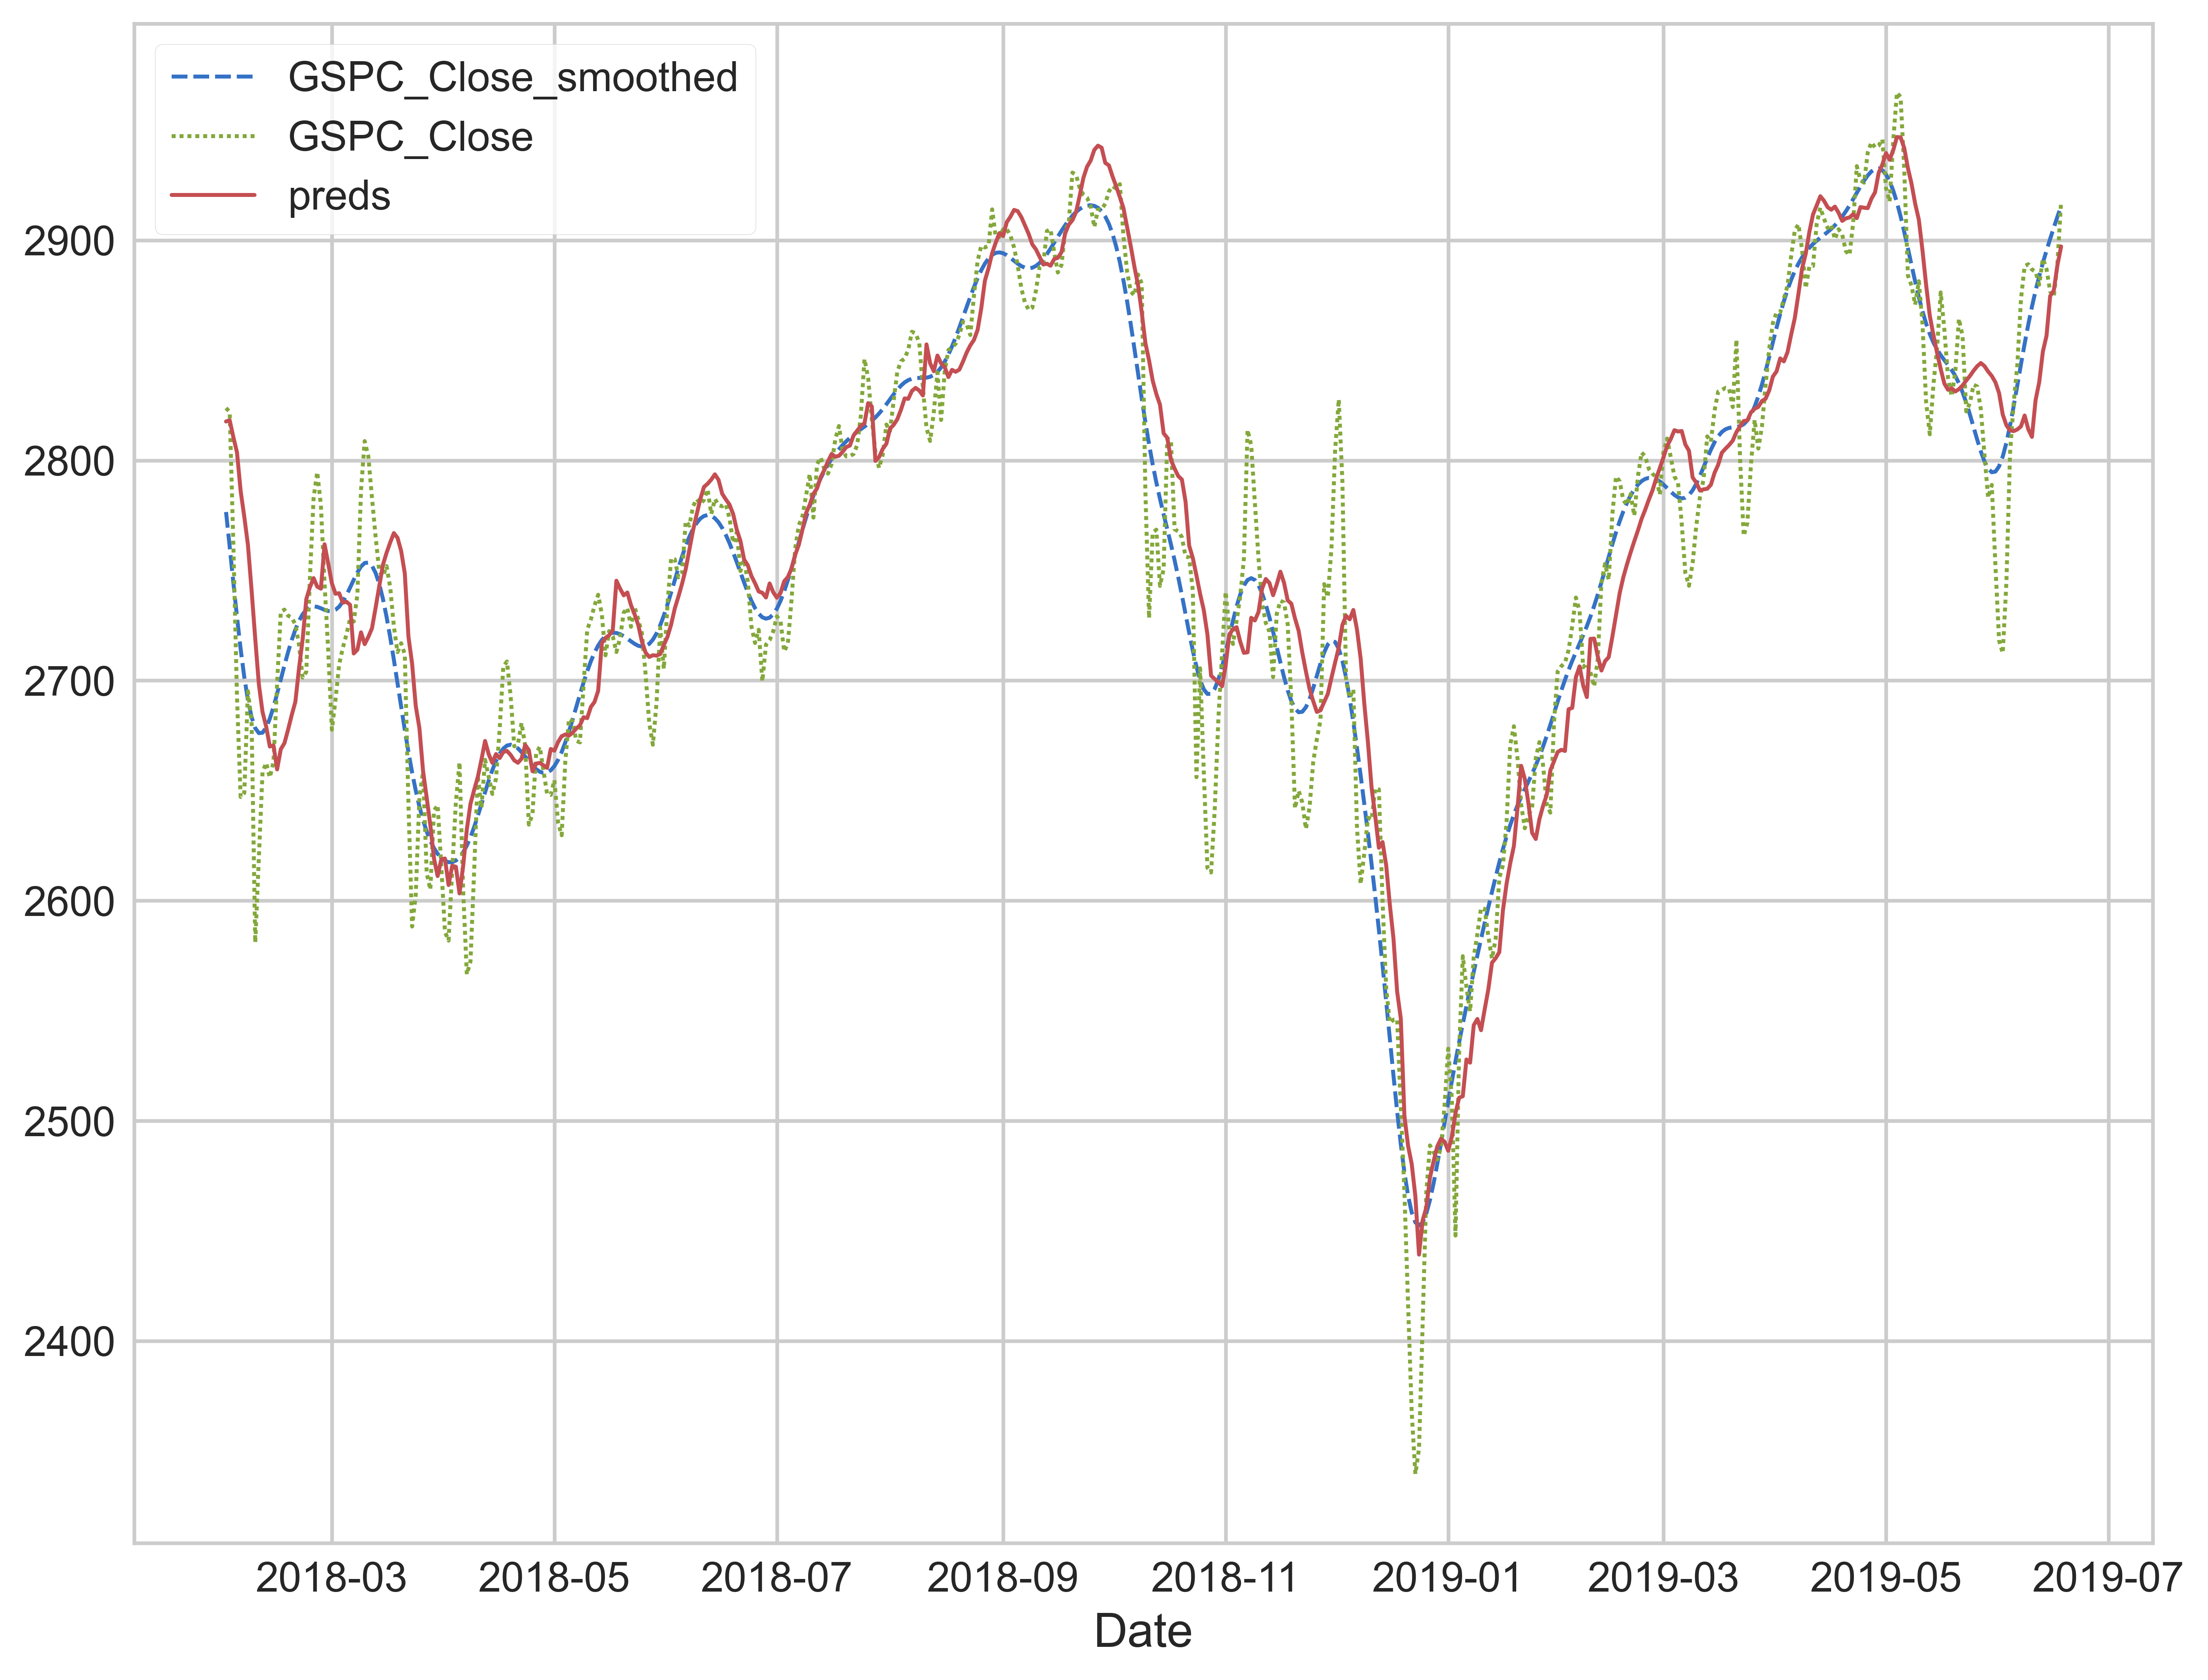

19.04094409047261


In [27]:
plot_XGBvalid_result_new=plot_XGBvalid_result.copy()
plot_XGBvalid_result_new['GSPC_Close_smoothed']=smooth_data(econ_data_ori,['GSPC_Close'],prediction_distance)['GSPC_Close_smoothed']
plot_XGBvalid_result_new['GSPC_Close']=(econ_data_ori['GSPC_Close'])

plot_XGBvalid_result_new['preds']=plot_XGBvalid_result_new['GSPC_Close_smoothed'].shift(periods=int(prediction_distance))*(plot_XGBvalid_result_new['preds']/100+1)
# plot_XGBvalid_result_new['preds_smoothed']=smooth_data(plot_XGBvalid_result_new,['preds'],30)['preds_smoothed']
plot_XGBvalid_result_new[target]=plot_XGBvalid_result_new['GSPC_Close_smoothed'].shift(periods=int(prediction_distance))*(plot_XGBvalid_result_new[target]/100+1)

plot_XGBvalid_result_new=plot_XGBvalid_result_new.dropna()


sns.set_style("whitegrid")

p_diff_err(plot_XGBvalid_result_new[target], plot_XGBvalid_result_new['preds'])

diff_err_scorer(plot_XGBvalid_result_new[target], plot_XGBvalid_result_new['preds'])

plt.figure(figsize=(11,8.5), dpi=600)

plot_cols=plot_XGBvalid_result_new.loc[:, plot_XGBvalid_result_new.columns != target]
plot_cols=plot_cols.columns

sns.lineplot(data=plot_XGBvalid_result_new.loc[:, plot_cols],hue_order=([ e for e in plot_cols if e is not 'preds' ]+['preds']))



plt.show()

valid_price_score = mean_absolute_error(plot_XGBvalid_result_new[target], plot_XGBvalid_result_new['preds'])
print(valid_price_score)

In [36]:
a=local_extrema(plot_XGBvalid_result_new['preds'])

b=local_extrema(plot_XGBvalid_result_new[target])

c= extrema_shifts (b,a)
print(c)
print('Average extrema shift = ' + str(c.mean()/pd.to_timedelta(1, unit='D').days))
print('Max extrema shift = ' + str(c.max()/pd.to_timedelta(1, unit='D').days))
print('Min extrema shift = ' + str(c.min()/pd.to_timedelta(1, unit='D').days))
print('Average negative extrema shift = ' + str(c[c<=pd.to_timedelta(0, unit='D')].mean()/pd.to_timedelta(1, unit='D').days))

2018-04-18    26 days
2018-06-28    -2 days
2018-07-12    -2 days
2018-10-07   -47 days
2018-11-22    -1 days
2019-01-10    48 days
2019-06-12    -4 days
dtype: timedelta64[ns]
Average extrema shift = 2 days 13:42:51.428571428
Max extrema shift = 48 days 00:00:00
Min extrema shift = -47 days +00:00:00
Average negative extrema shift = -12 days +19:12:00
